## set up workspace

In [1]:
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid')

from covid_model_deaths.preprocessing import expanding_moving_average_by_location

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
warnings.simplefilter('ignore')


## define smoother

In [2]:
def add_moving_average(data: pd.DataFrame, smoooth_var: str,
                       rate_threshold: float, n_smooths: int = 3) -> pd.DataFrame:
    """Smooths over the log age specific death rate.

    Parameters
    ----------
    data
        The data with the age specific death rate to smooth over.
    rate_threshold
        The minimum age specific death rate.  Values produced in the
        averaging will be pinned to this.

    Returns
    -------
        The same data with the log asdr replaced with its average and a new
        column with the original observed asdr.

    """
    required_columns = ['location_id', 'Date', 'Days', smoooth_var]
    assert set(required_columns).issubset(data.columns)
    data[f'Observed {smoooth_var}'] = data[smoooth_var]
    # smooth n times
    for i in range(n_smooths):
        moving_average = expanding_moving_average_by_location(data, smoooth_var)
        # noinspection PyTypeChecker
        moving_average[moving_average < rate_threshold] = rate_threshold
        data = data.set_index(['location_id', 'Date'])
        data = (pd.concat([data.drop(columns=smoooth_var), moving_average], axis=1)
                .fillna(method='pad')
                .reset_index())

    return data


## load data and smooth

In [3]:
df = pd.read_csv('/ihme/covid-19/model-inputs/best/deaths.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['ln(death rate)'] = np.log(df['Death rate'])
df = df.loc[df['Country/Region'] == 'United States of America']
df = df.loc[df['location_id'] != 102]

states = df['Location'].unique().tolist()

smooth_dfs = []
for n_smooths in range(11):
    if n_smooths == 0:
        smooth_dfs.append(df.copy())
    else:
        smooth_dfs.append(add_moving_average(df.copy(), 'ln(death rate)', -np.inf, n_smooths))


## make pictures

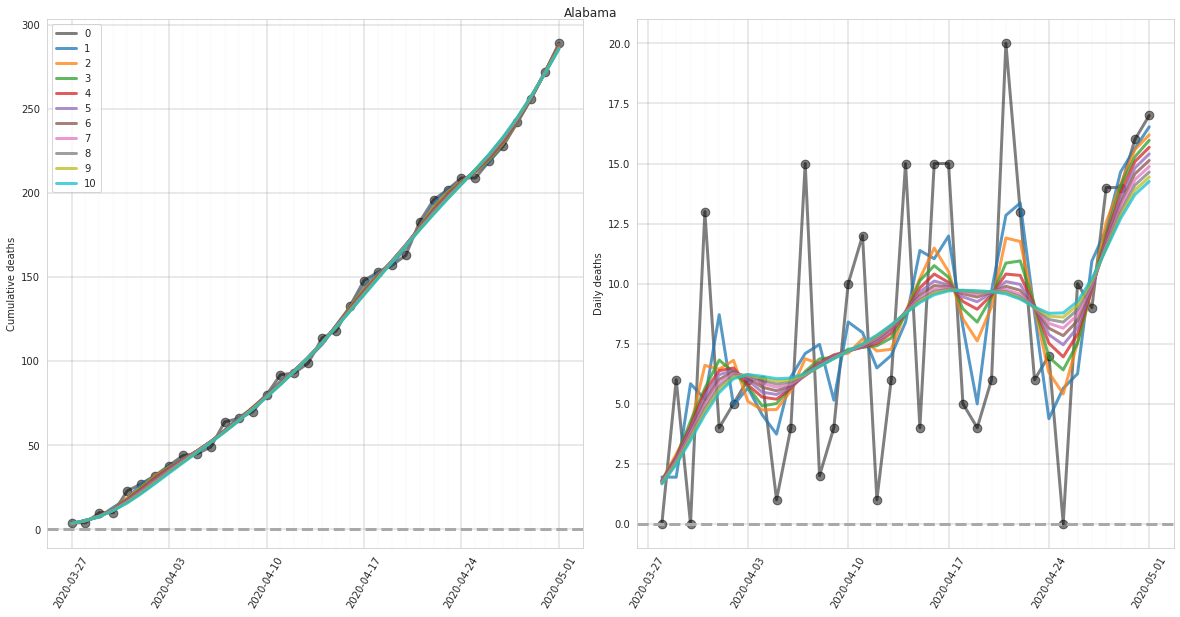

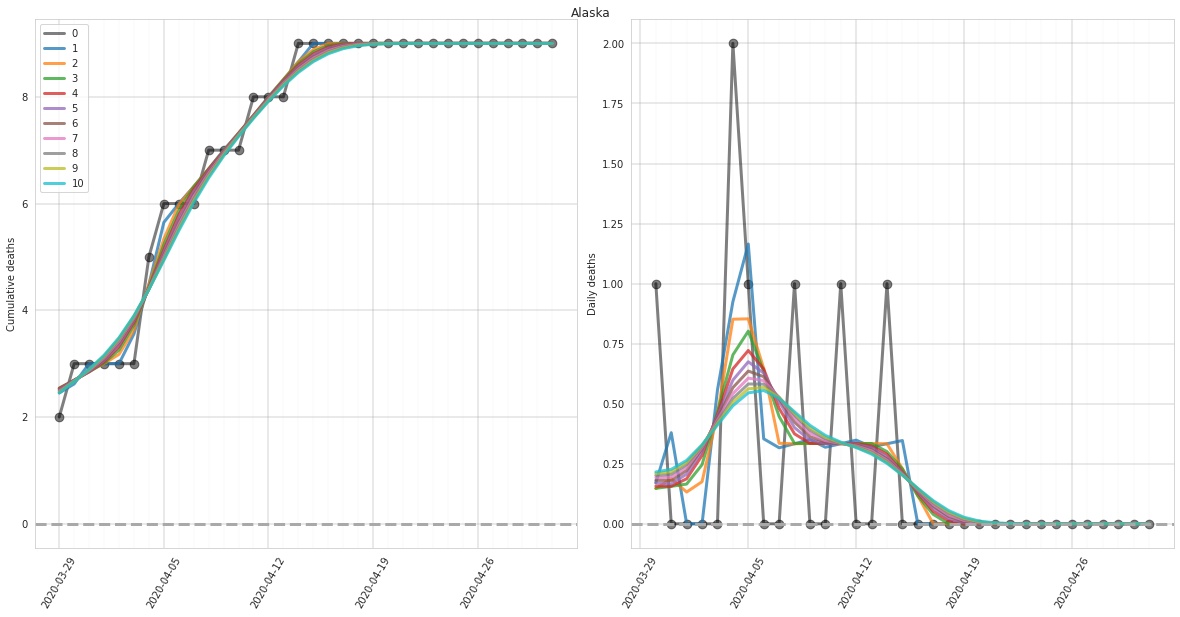

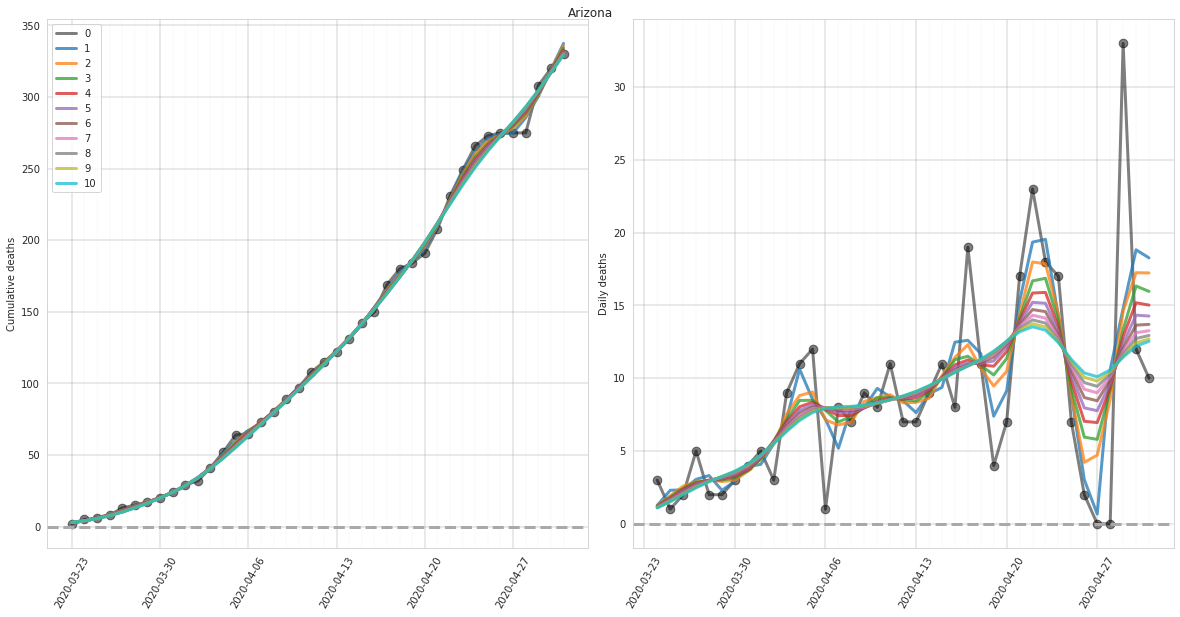

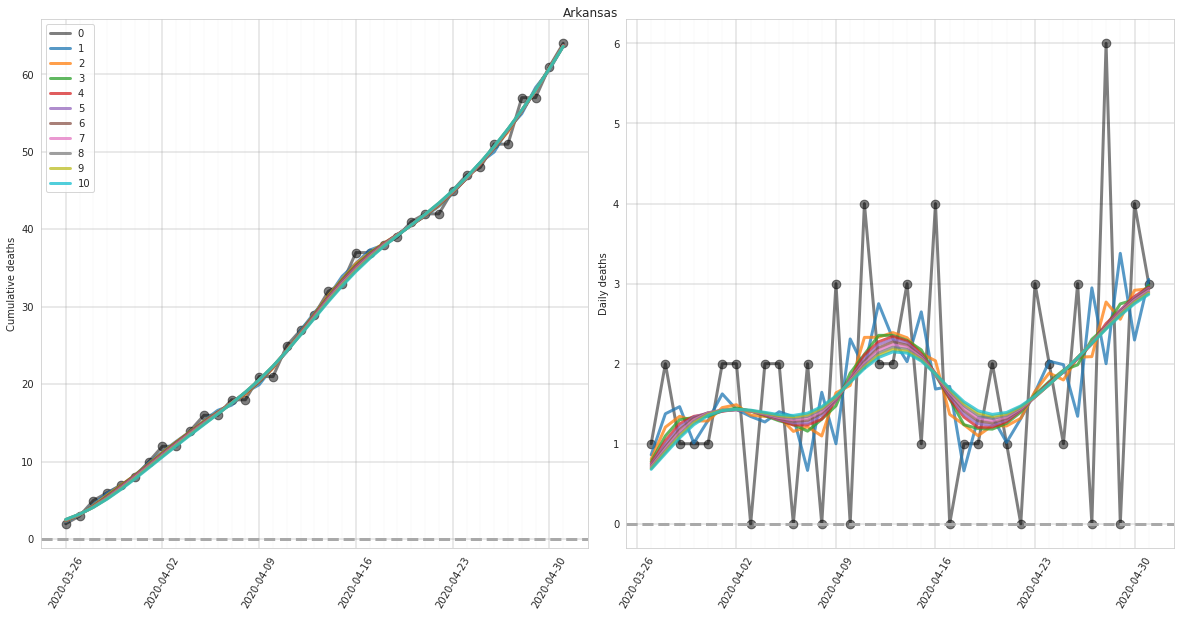

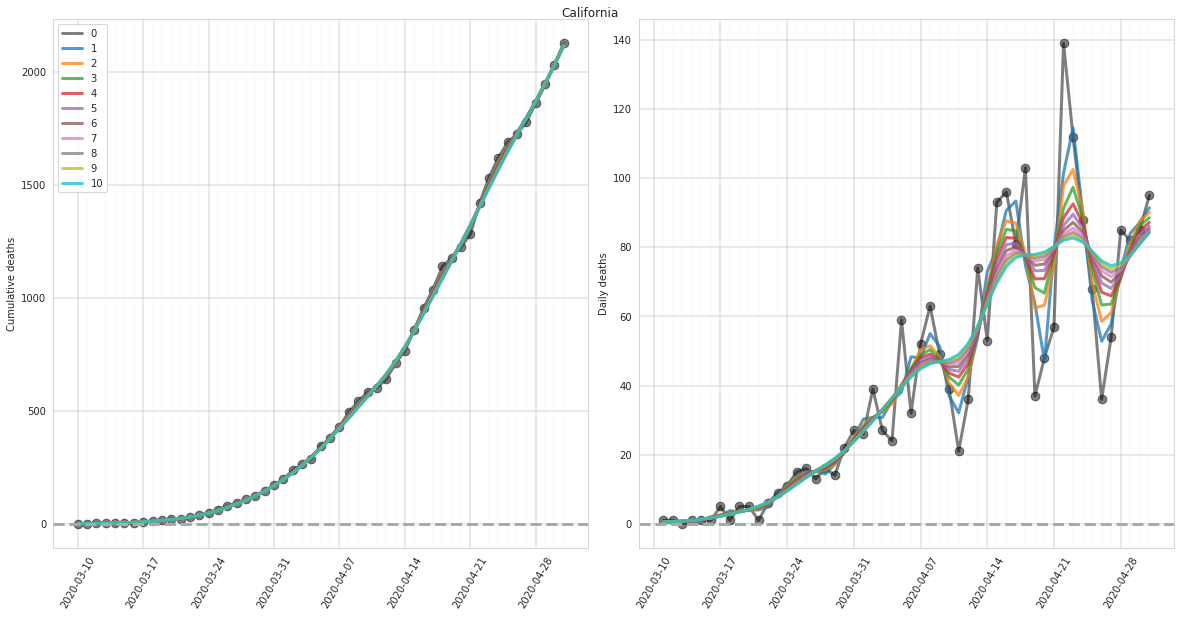

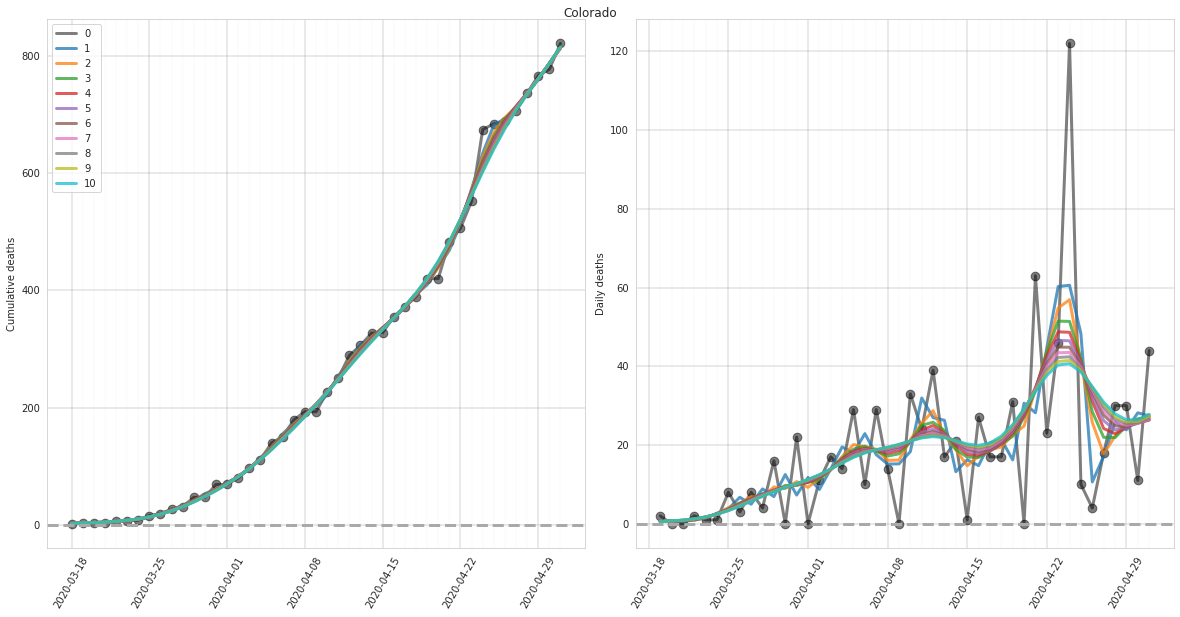

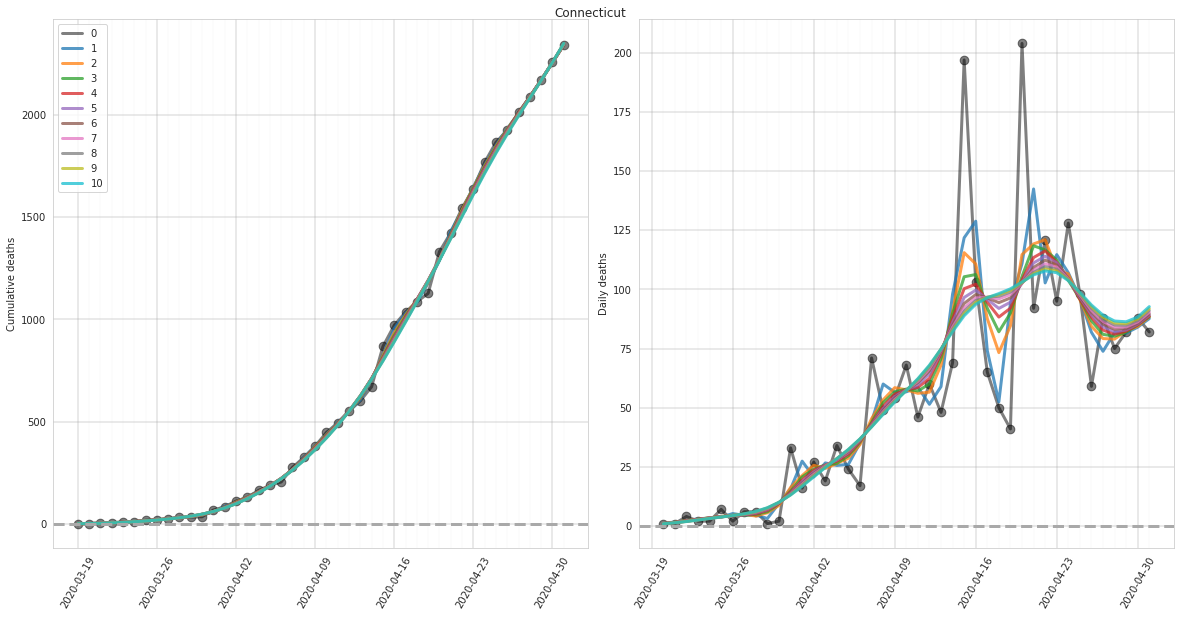

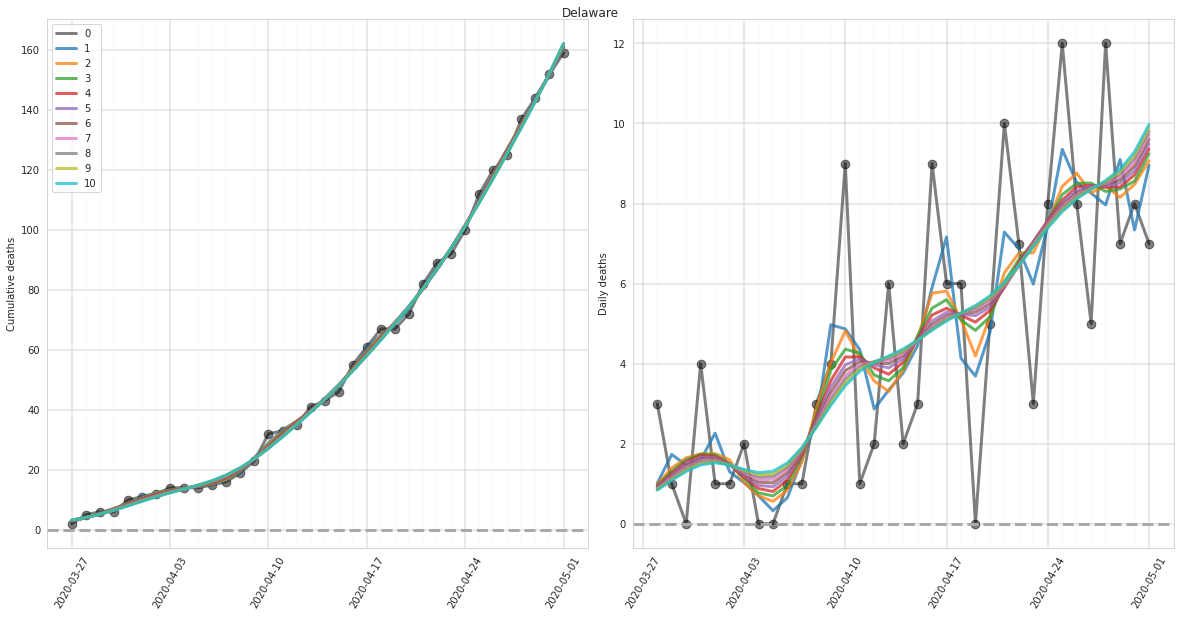

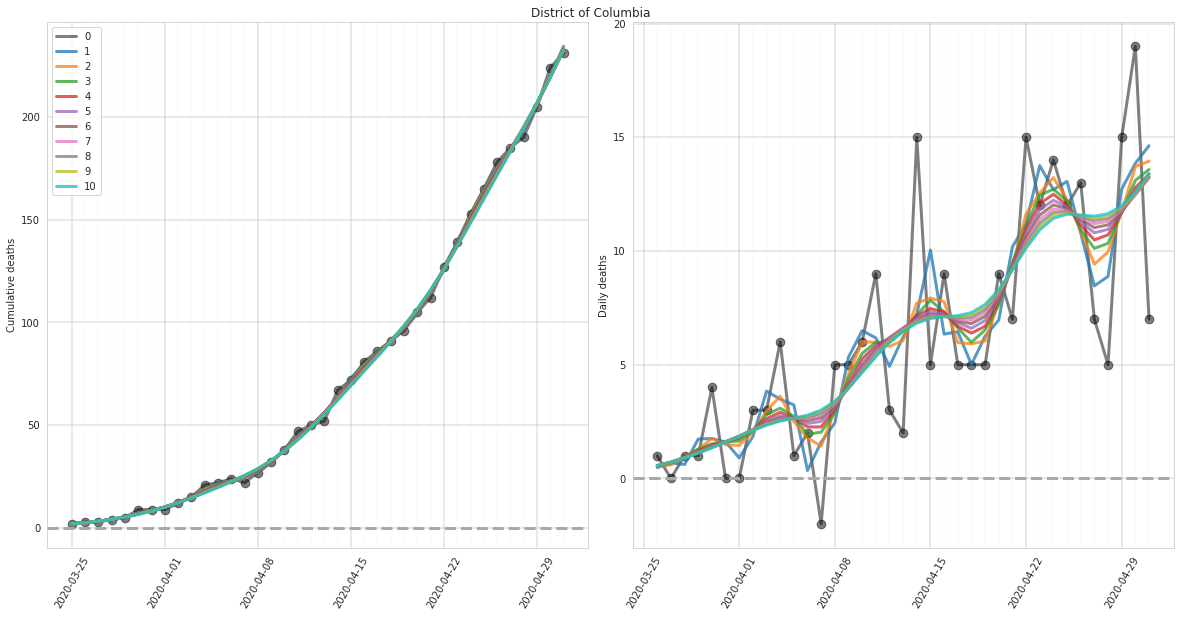

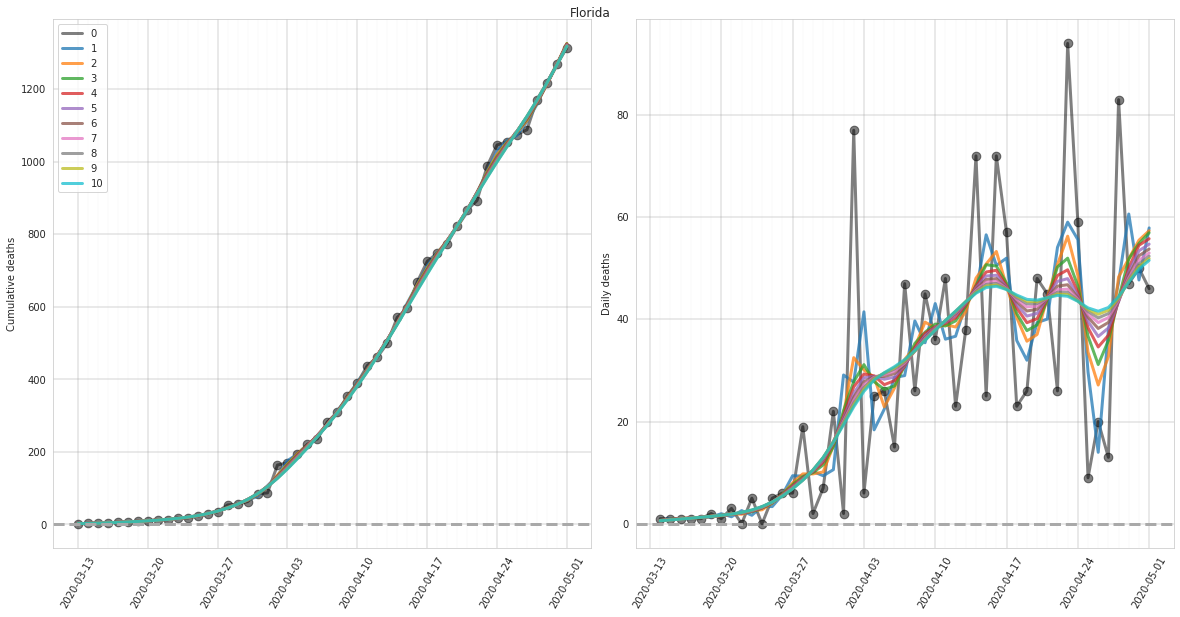

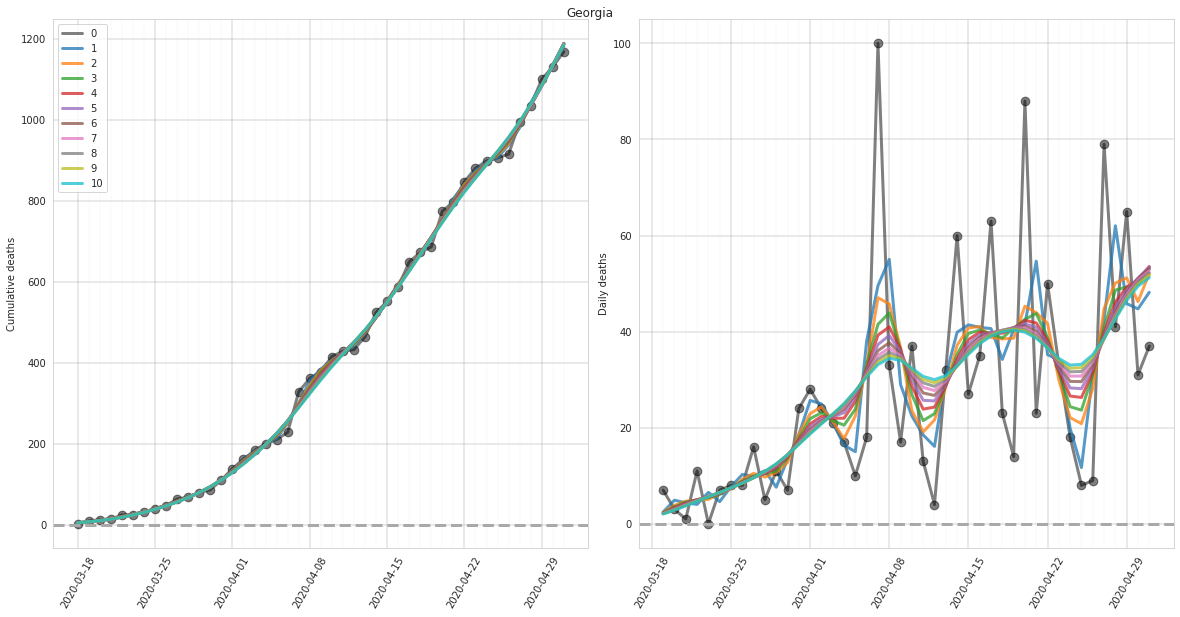

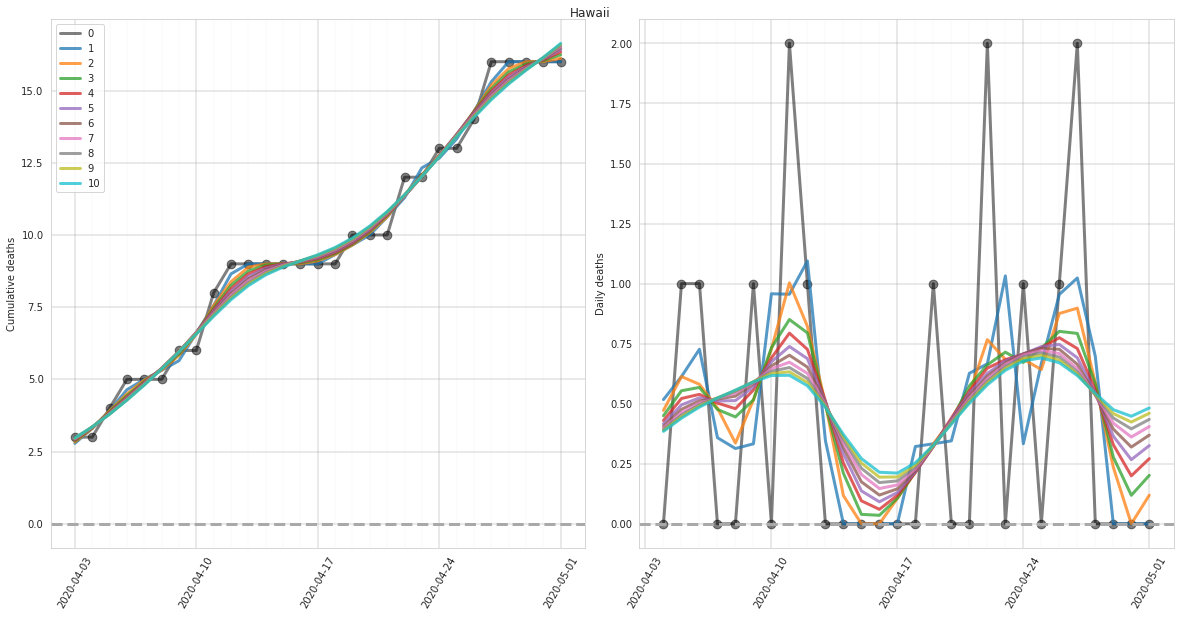

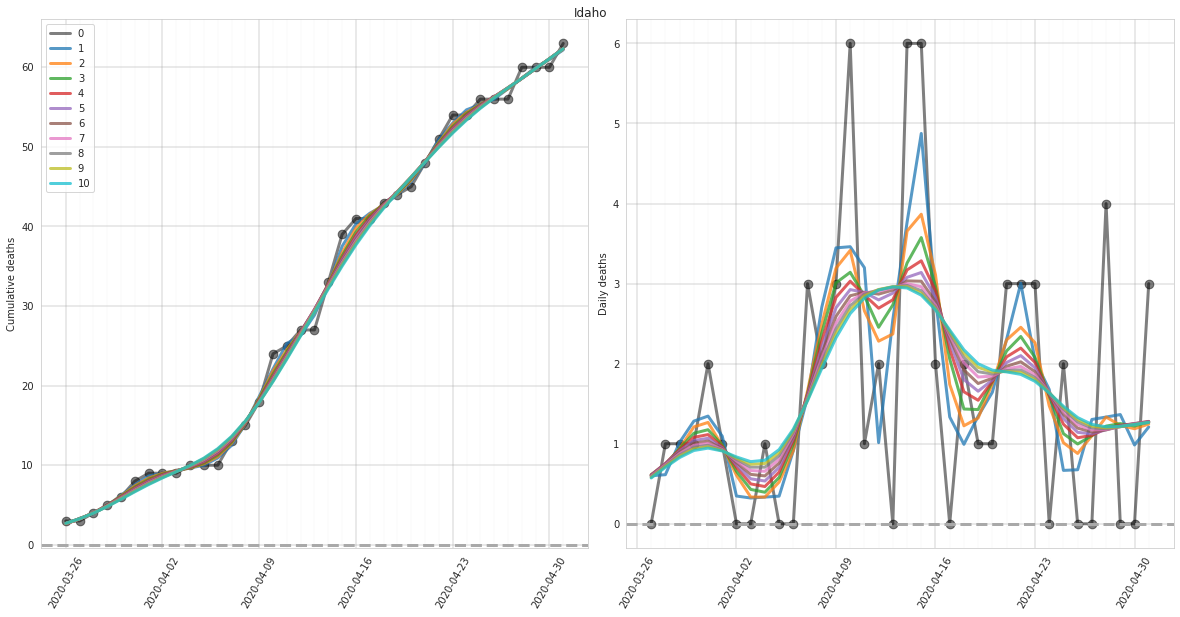

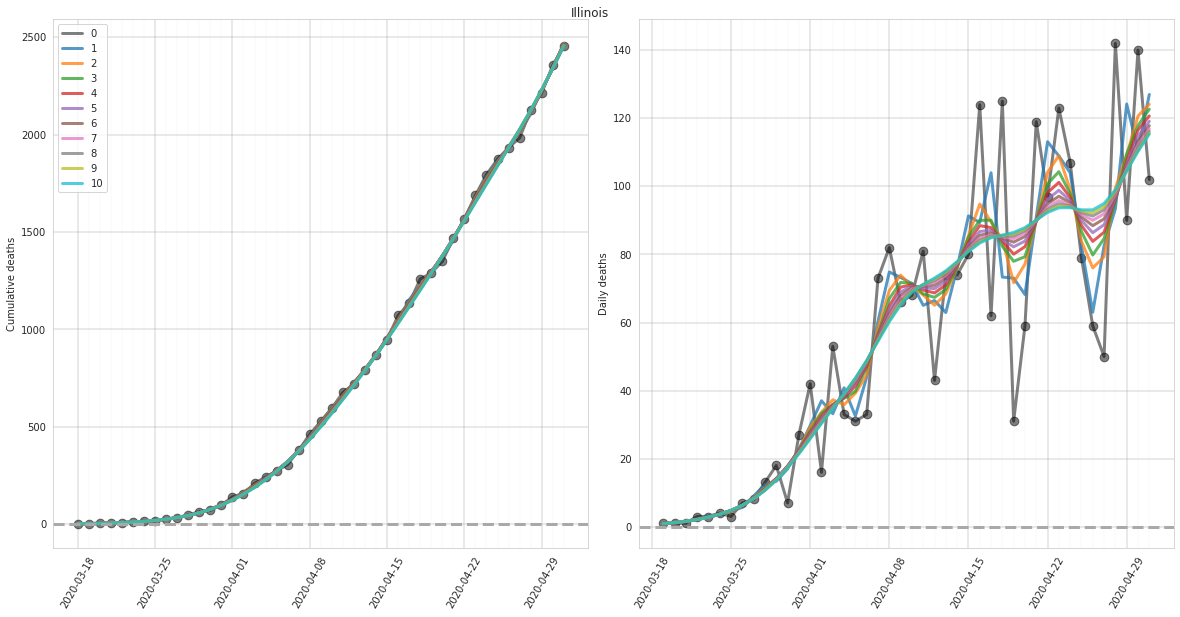

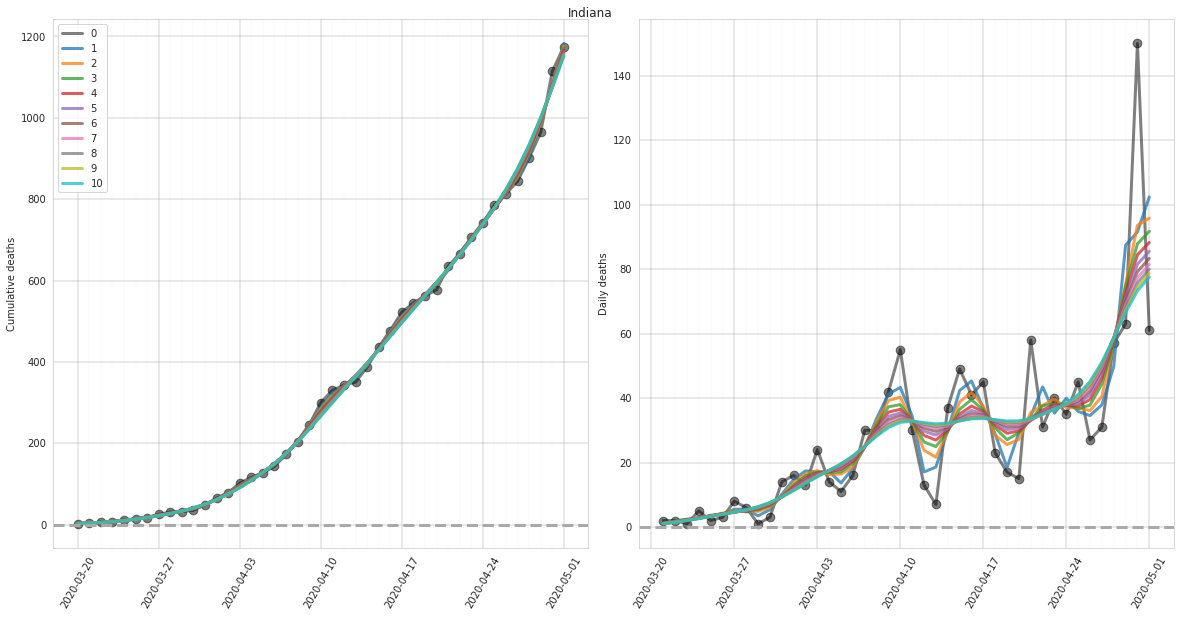

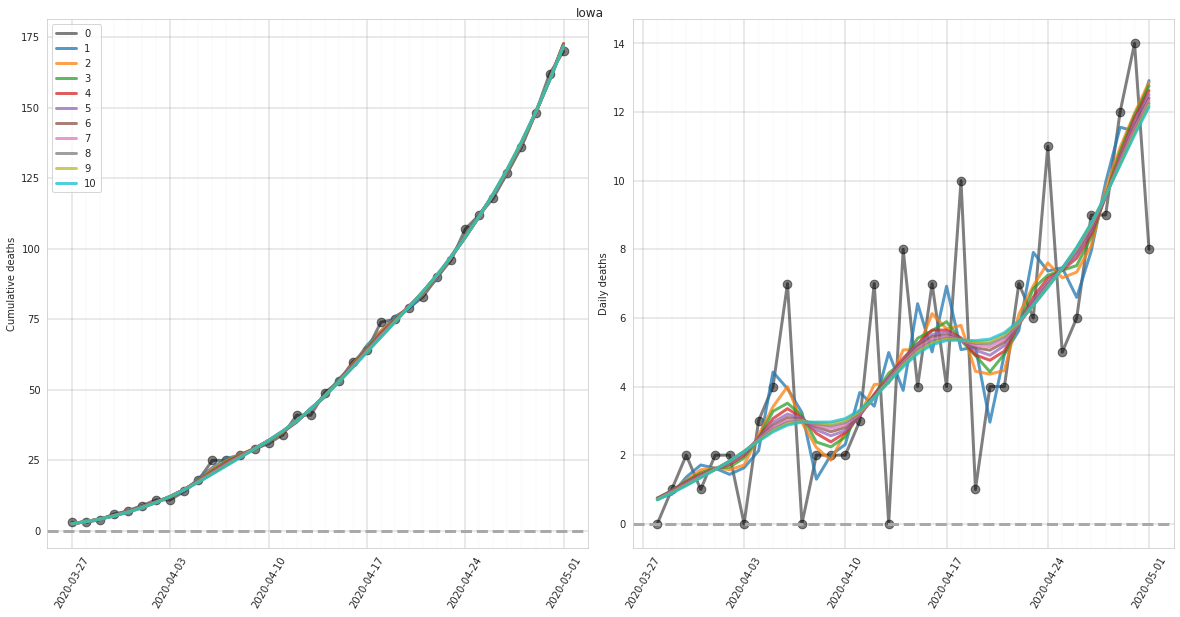

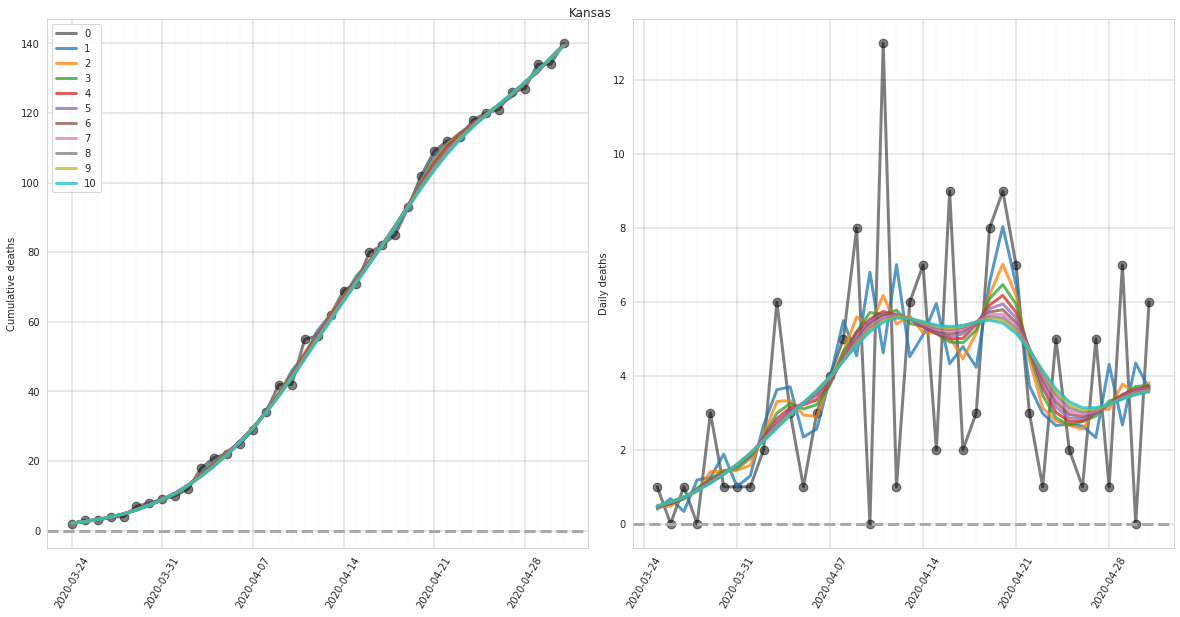

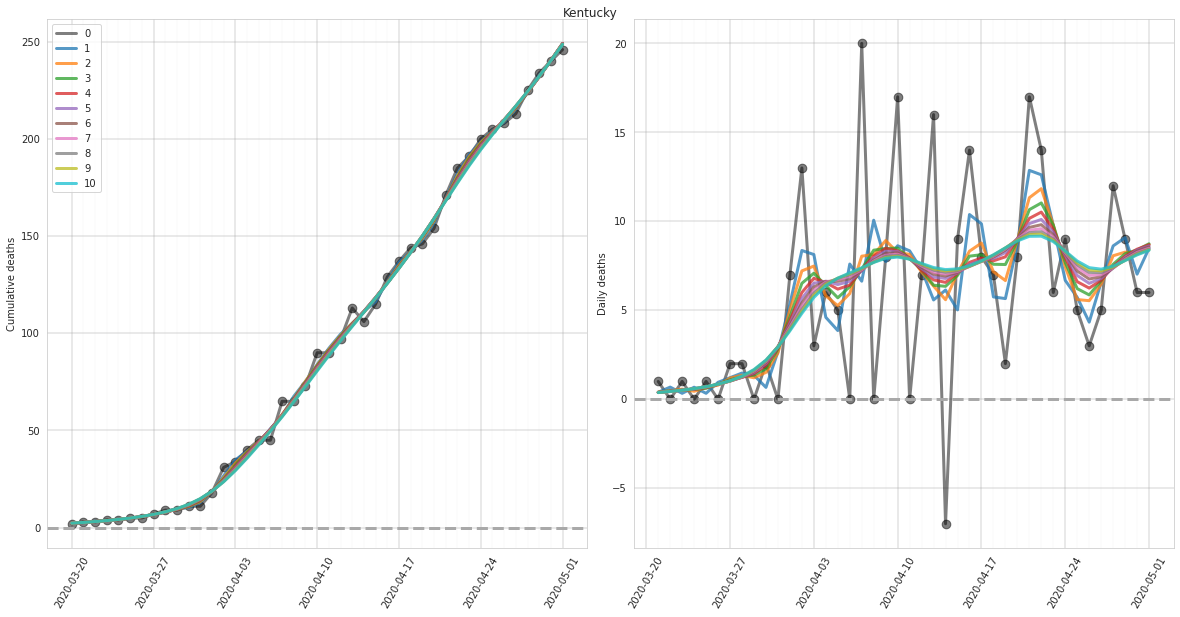

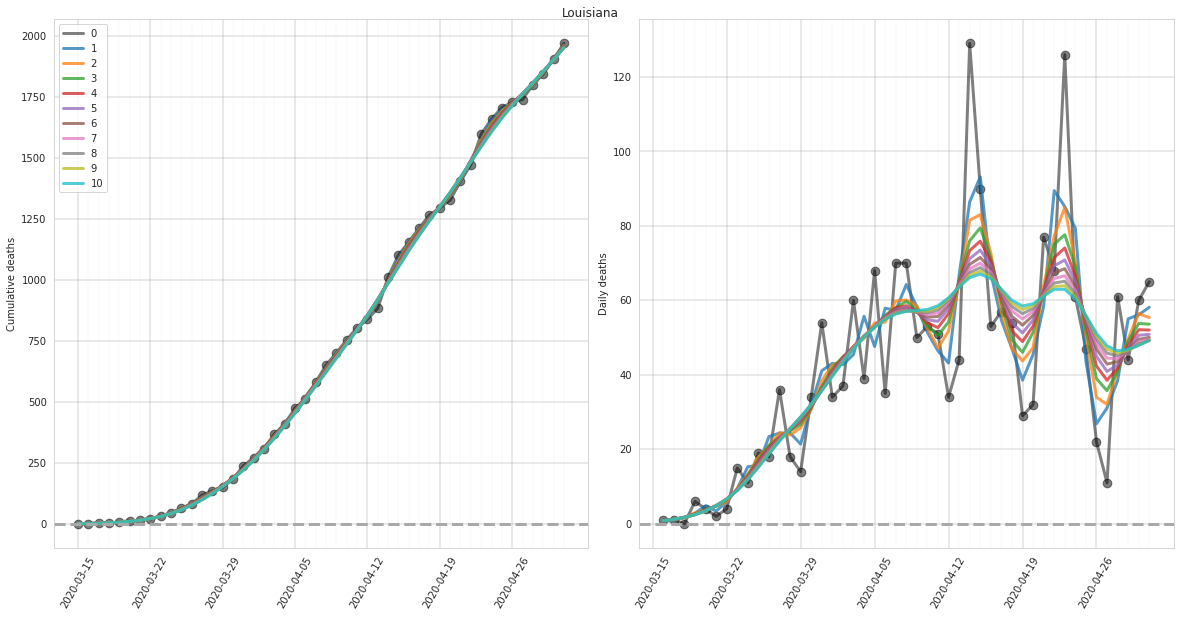

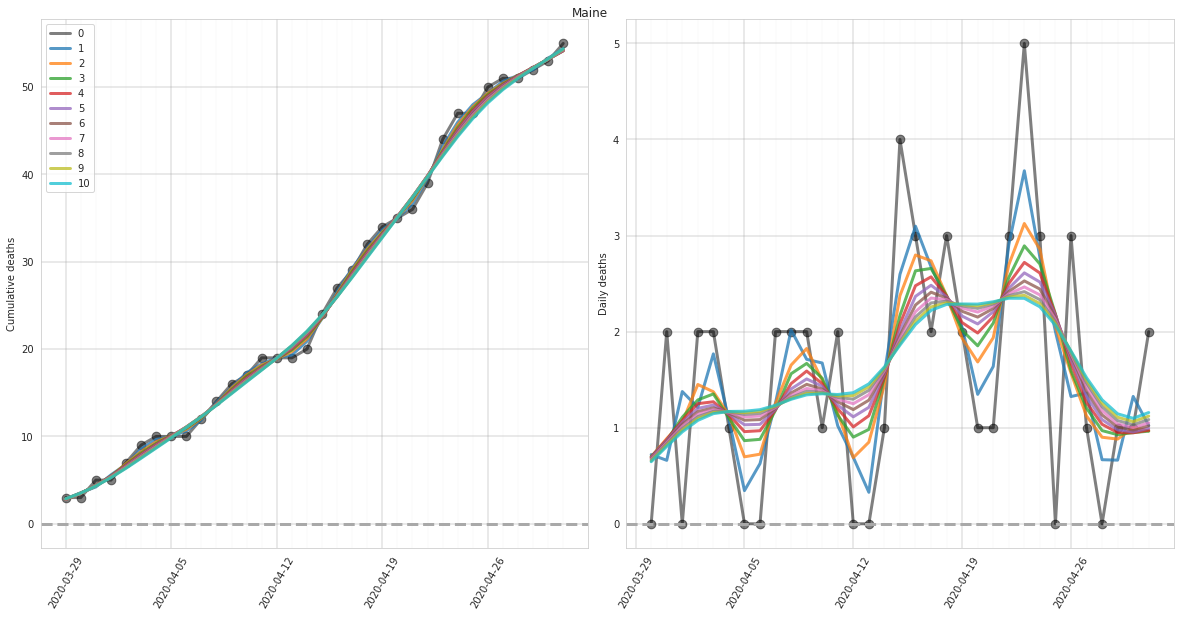

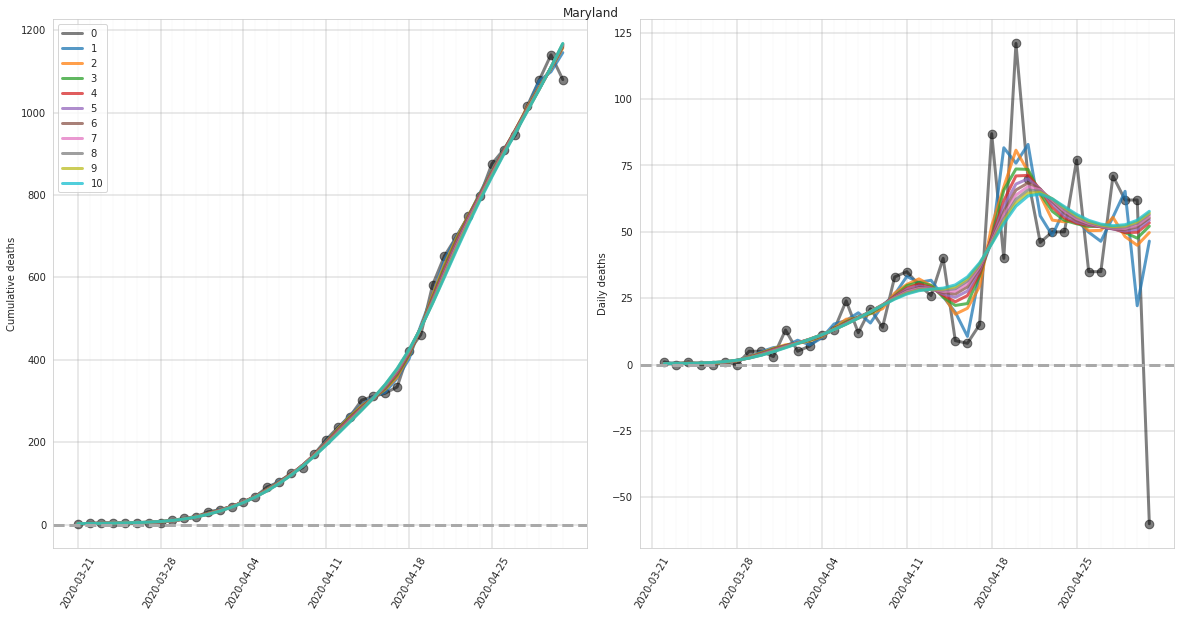

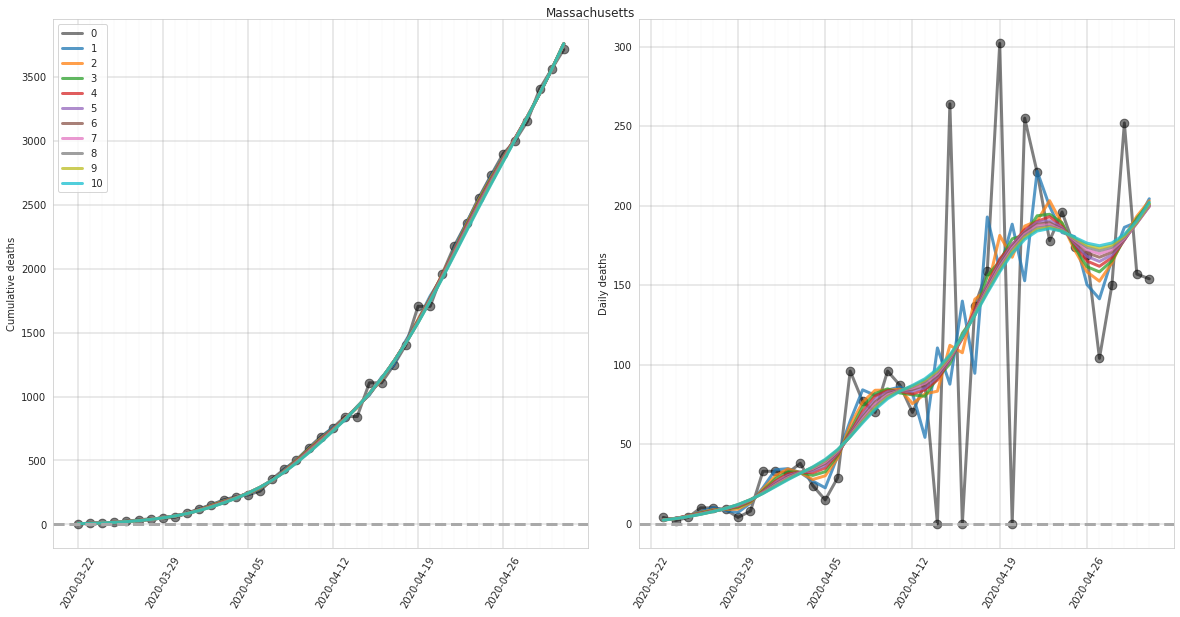

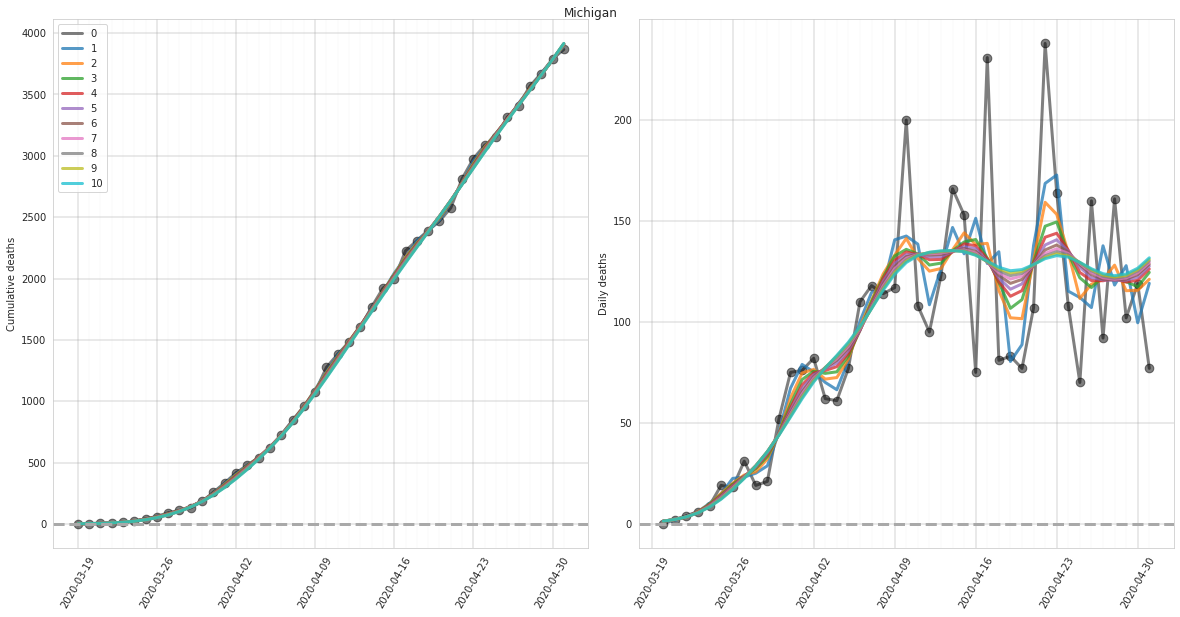

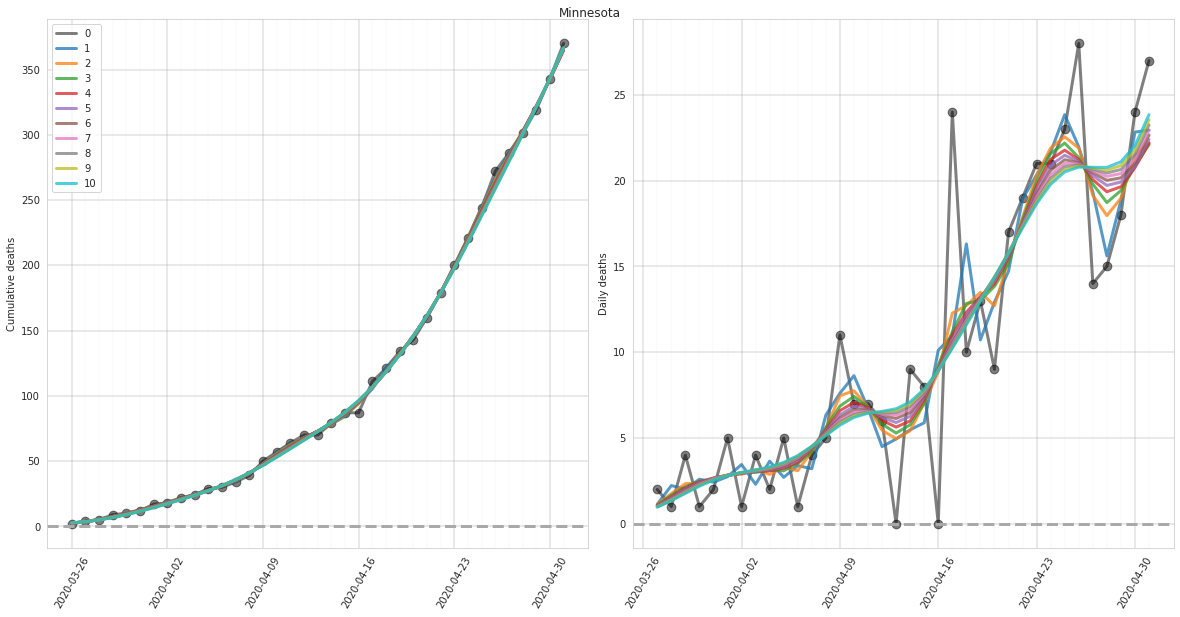

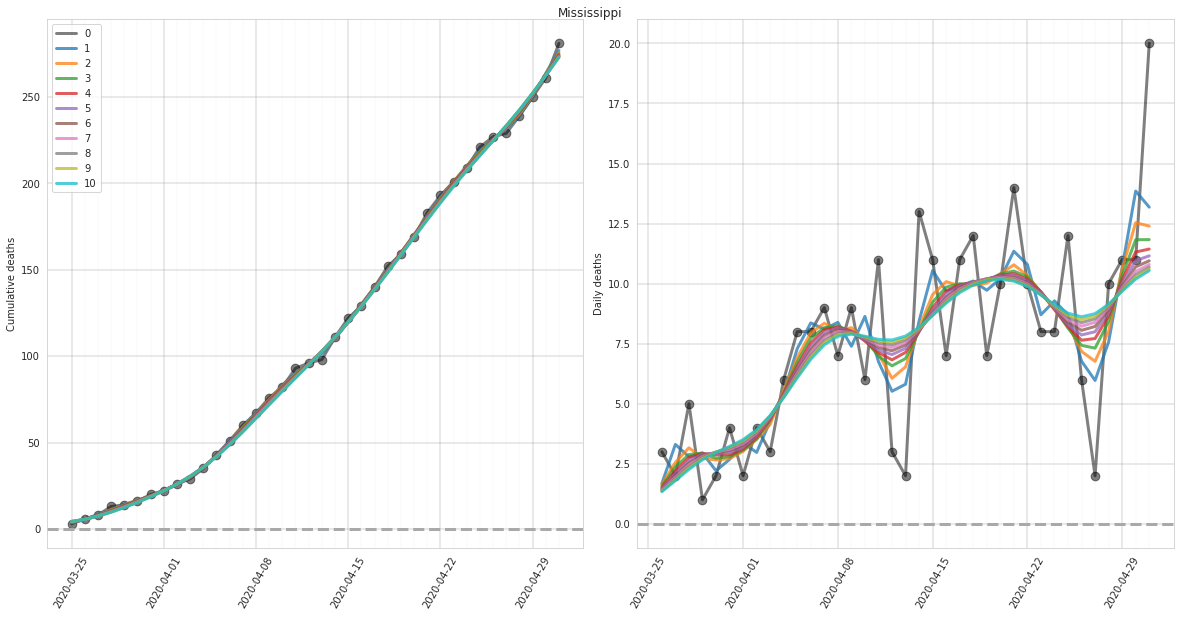

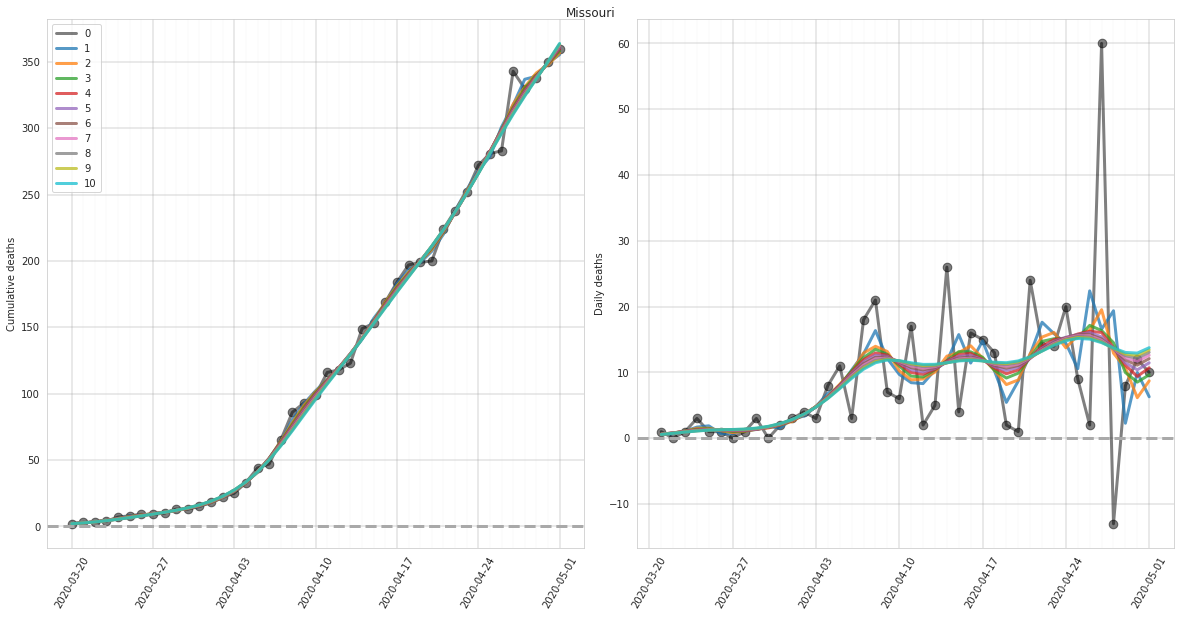

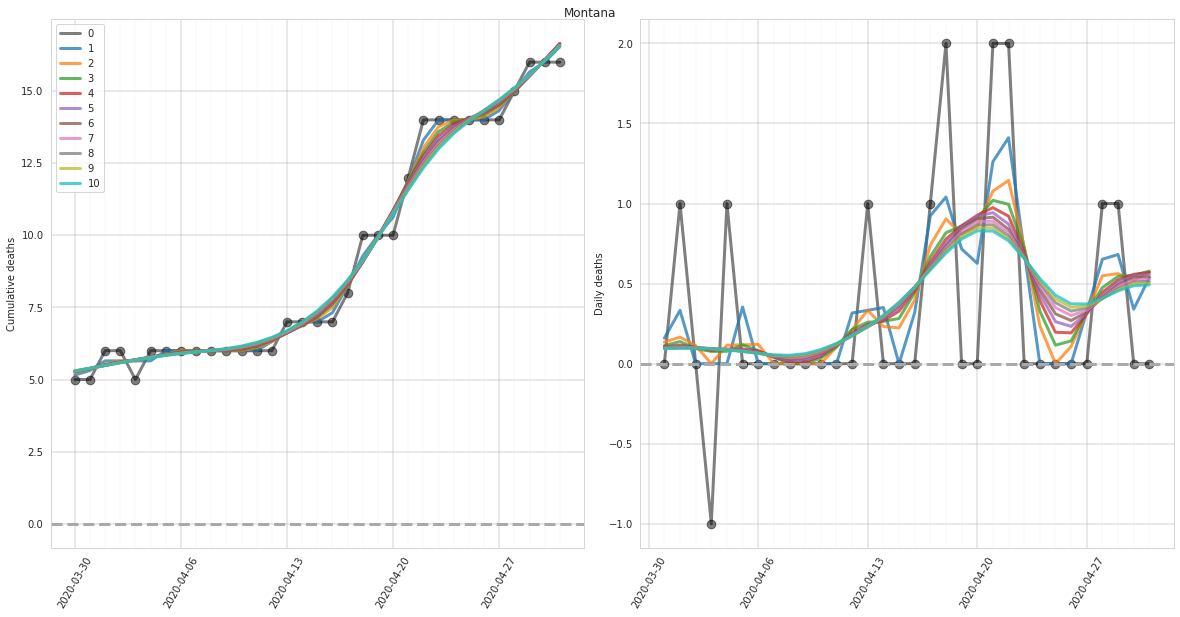

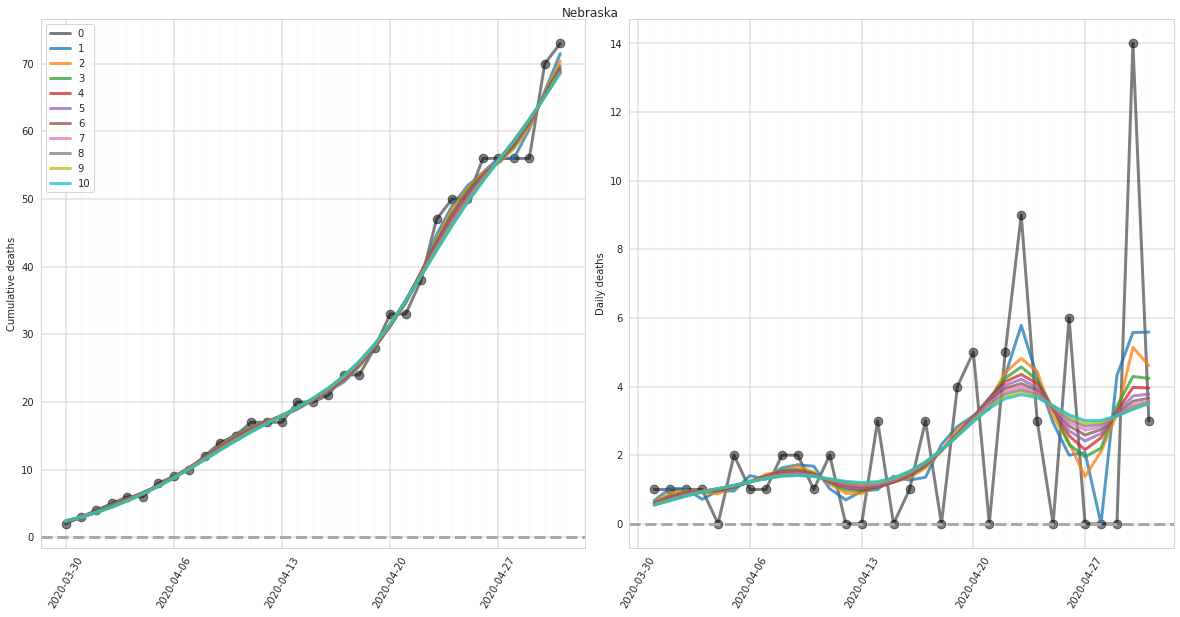

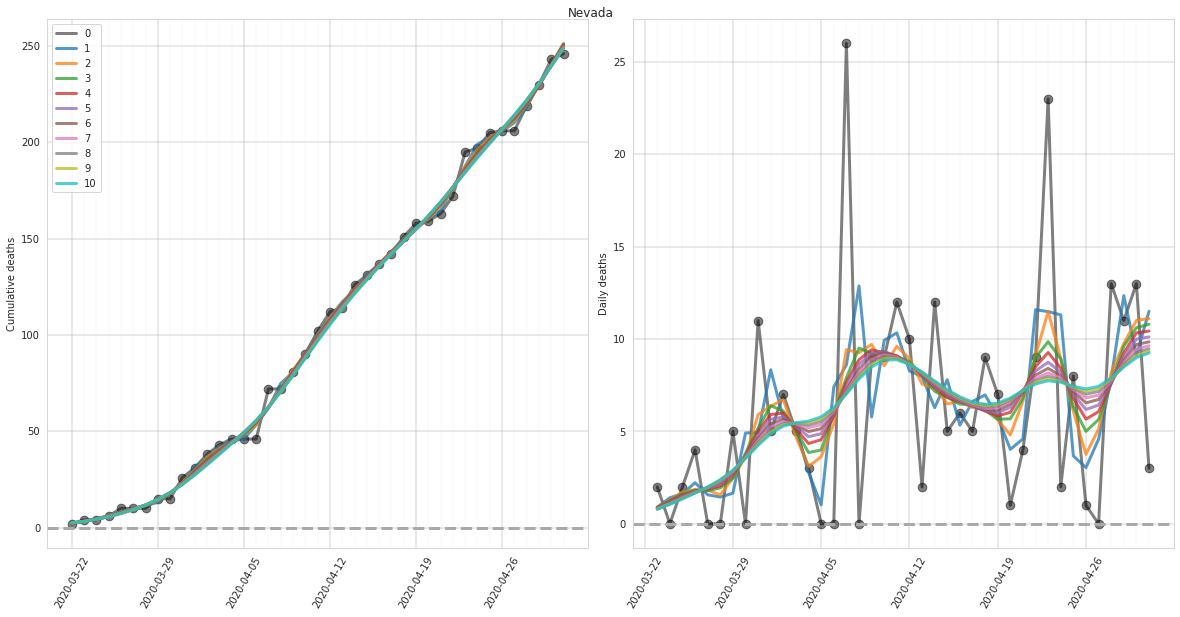

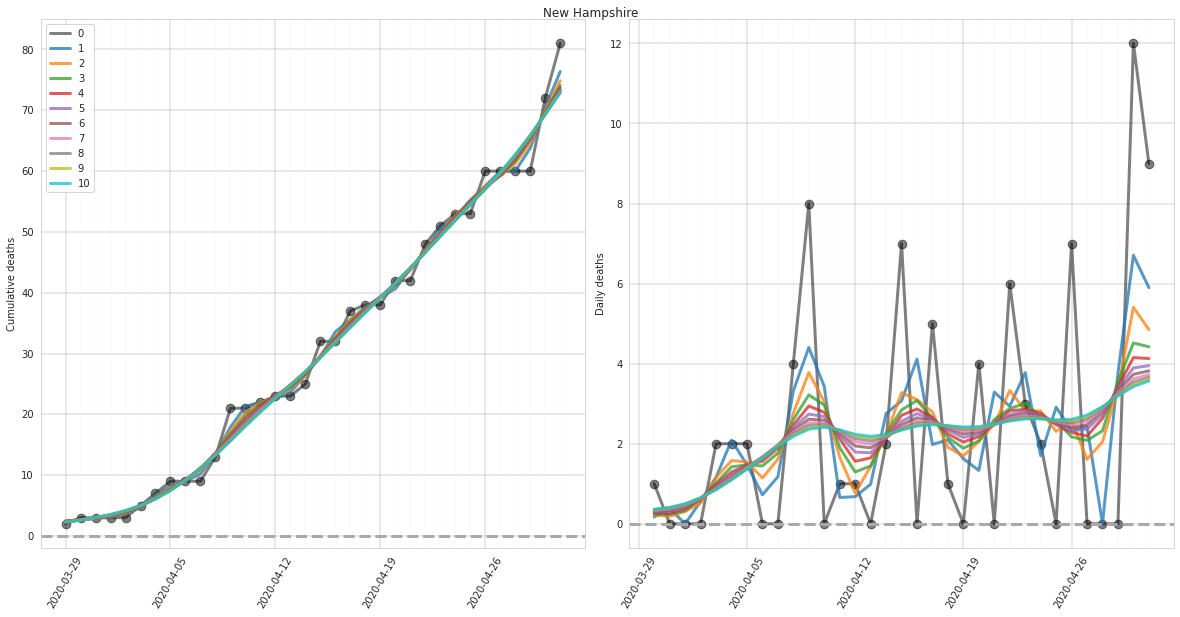

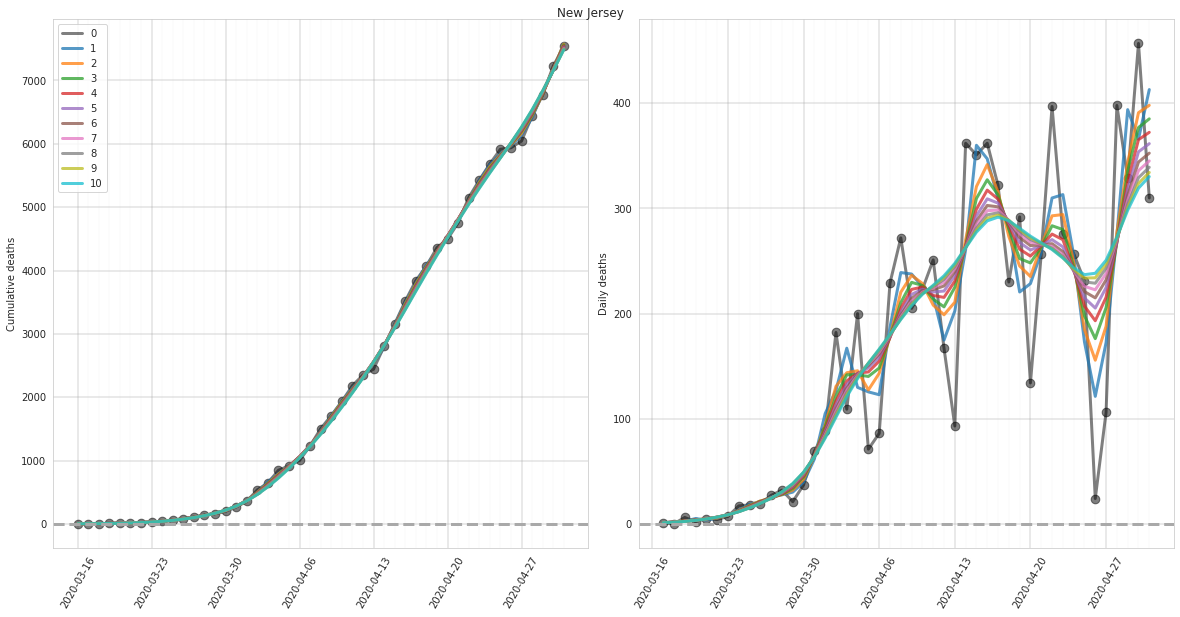

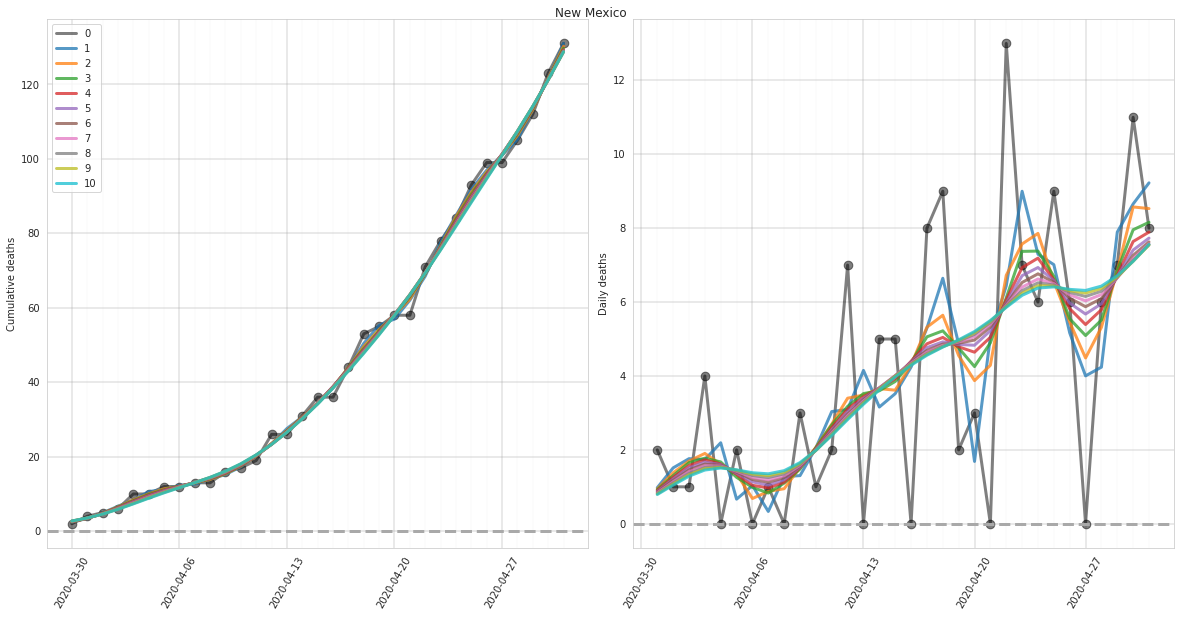

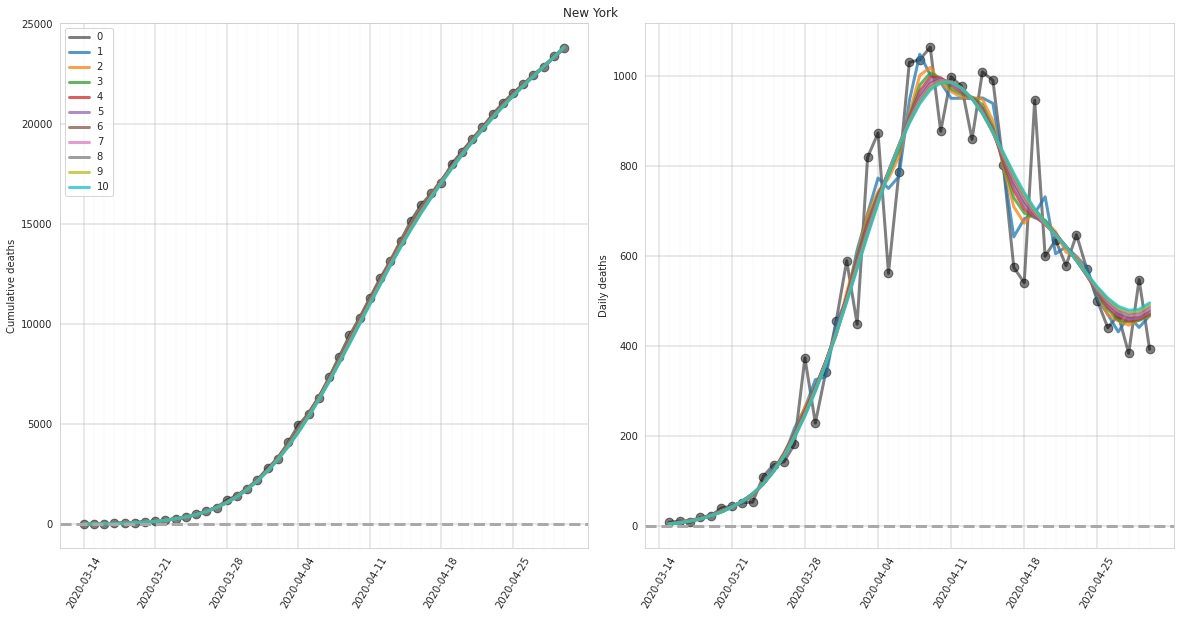

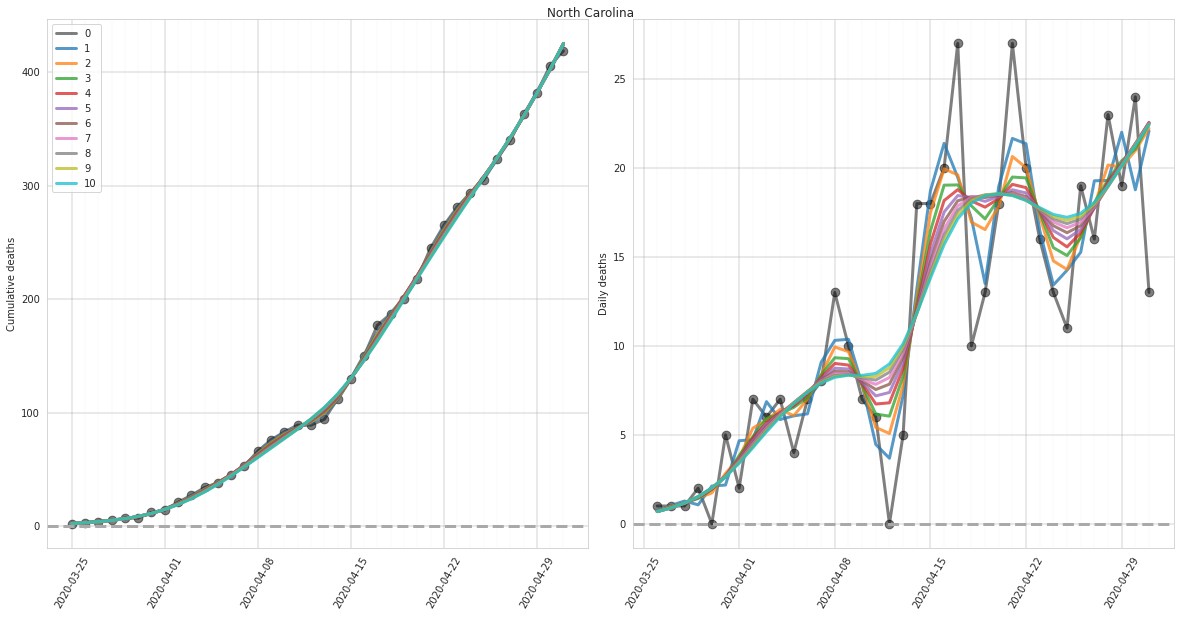

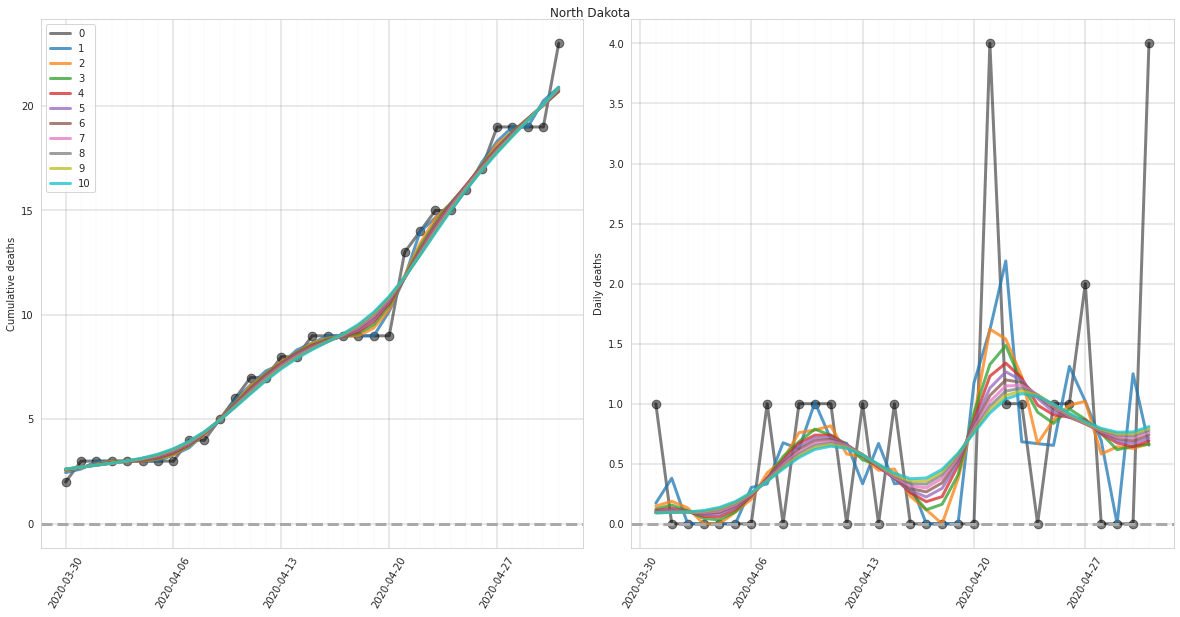

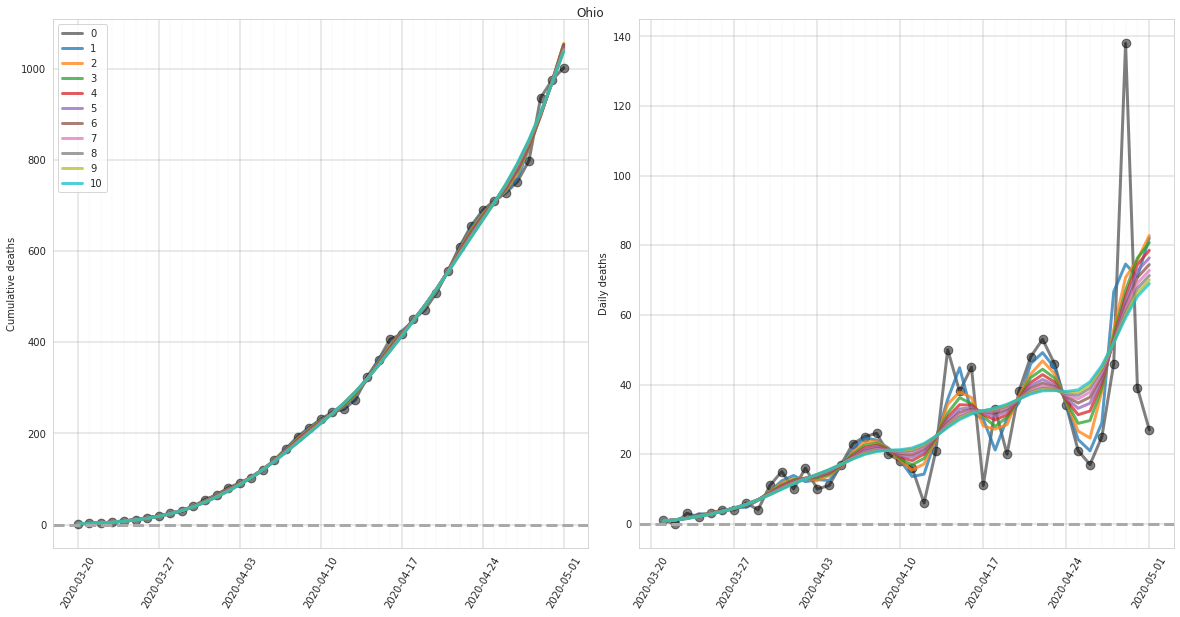

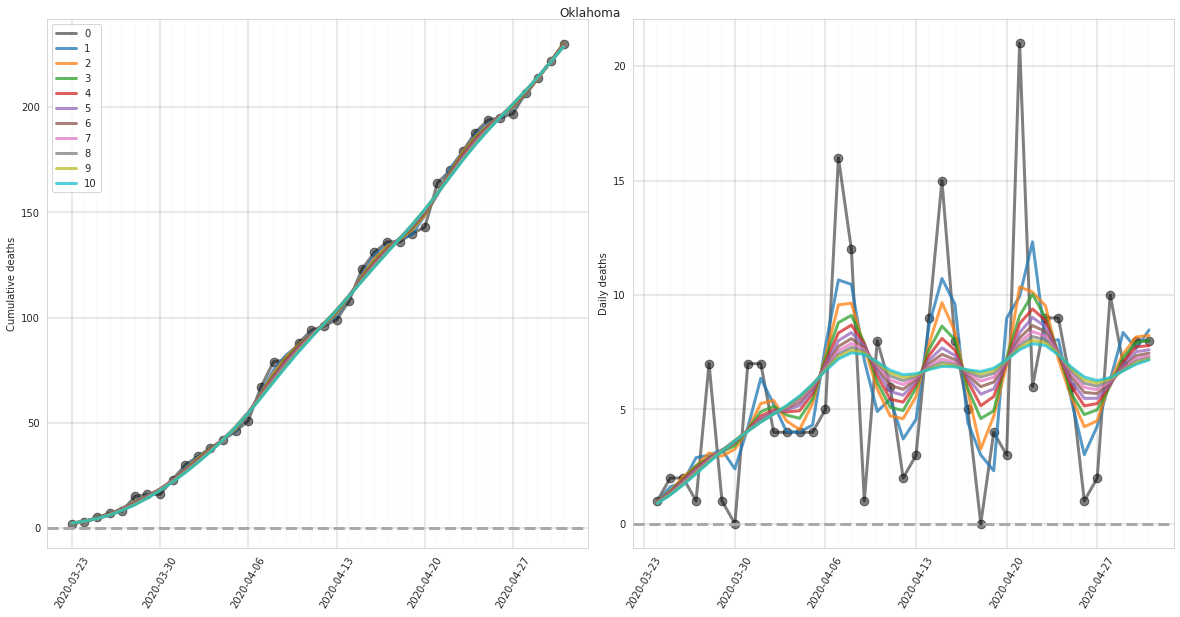

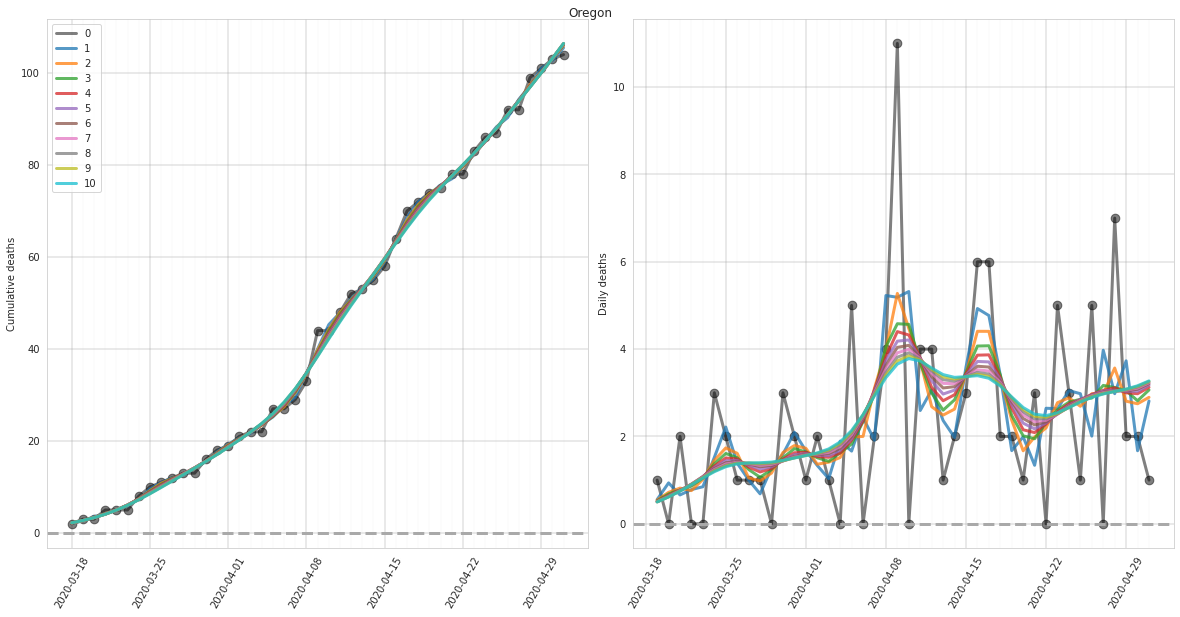

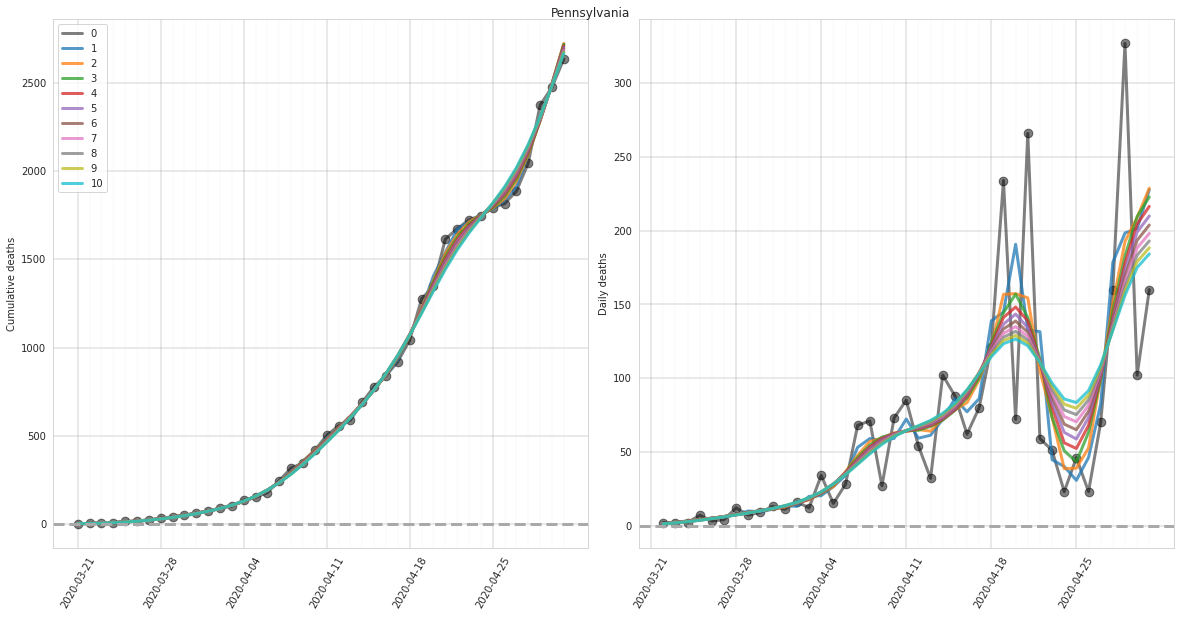

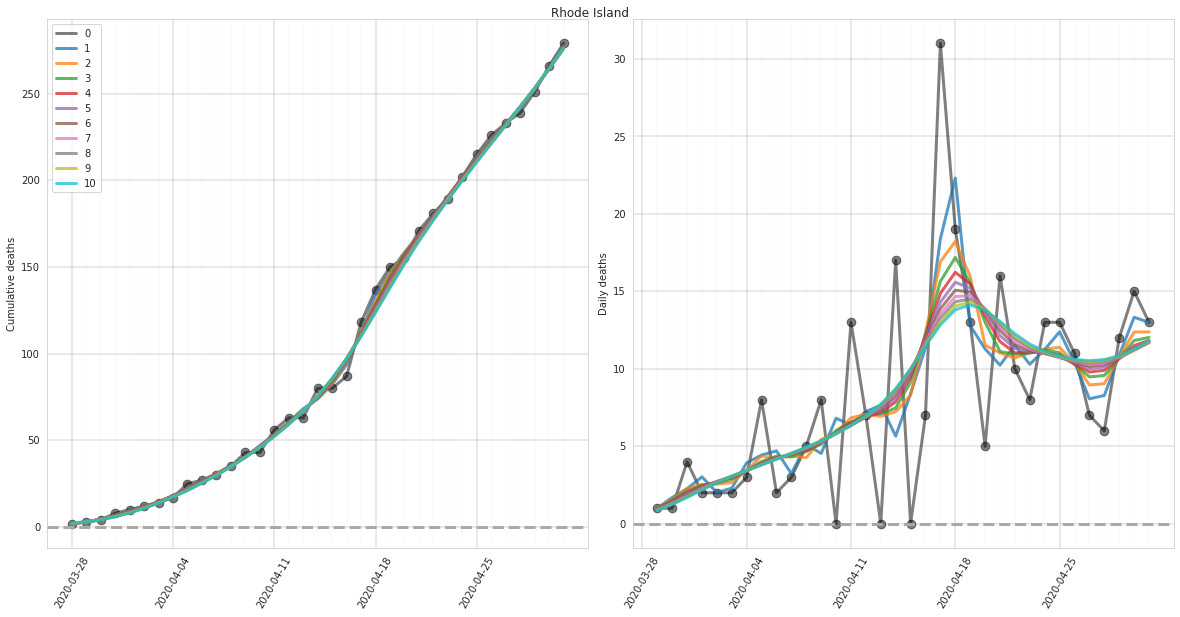

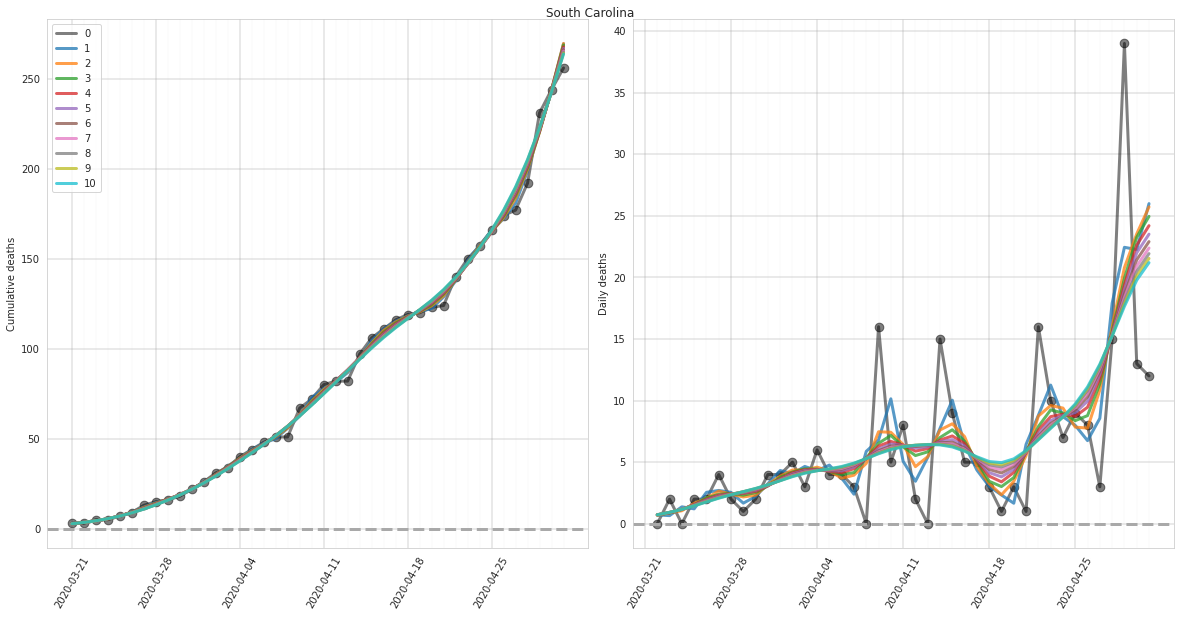

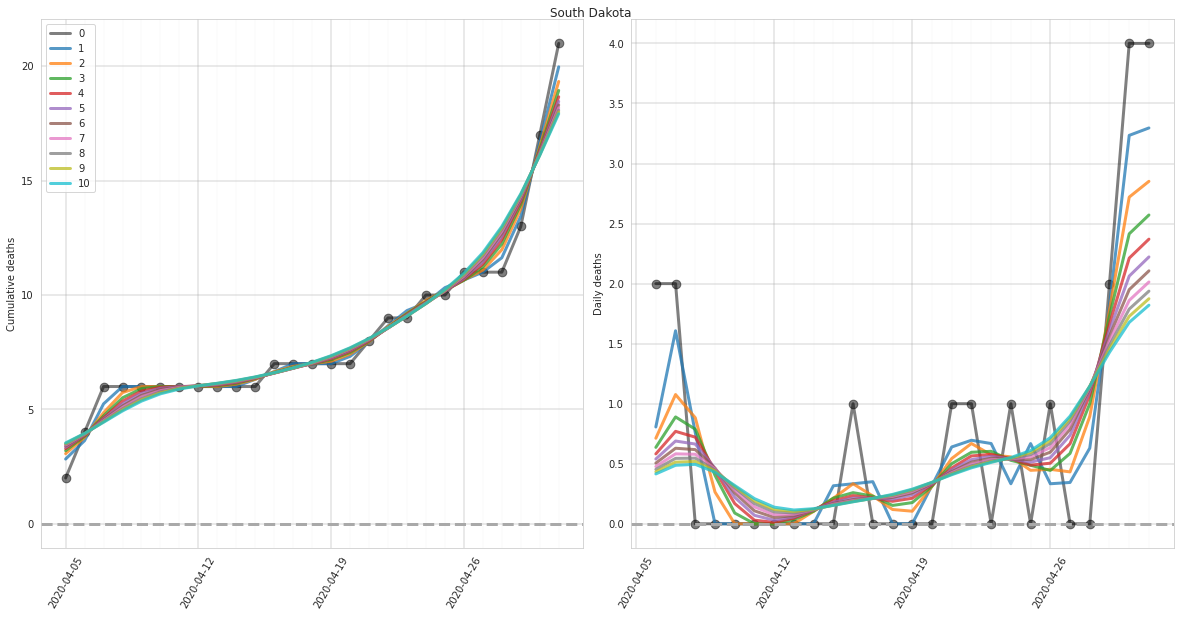

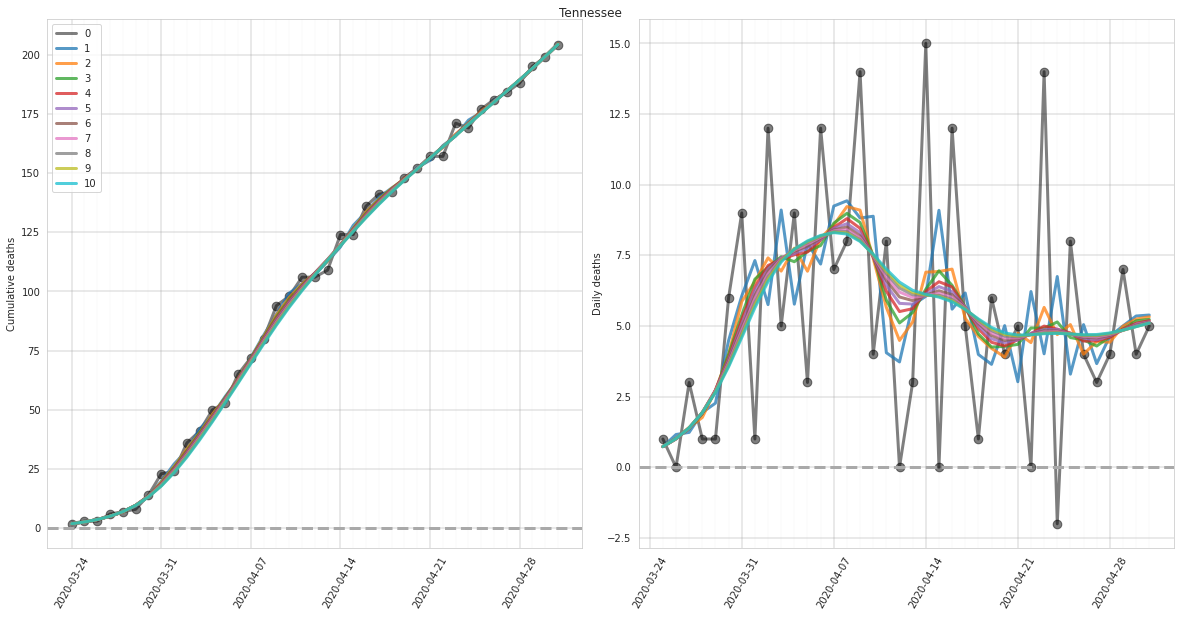

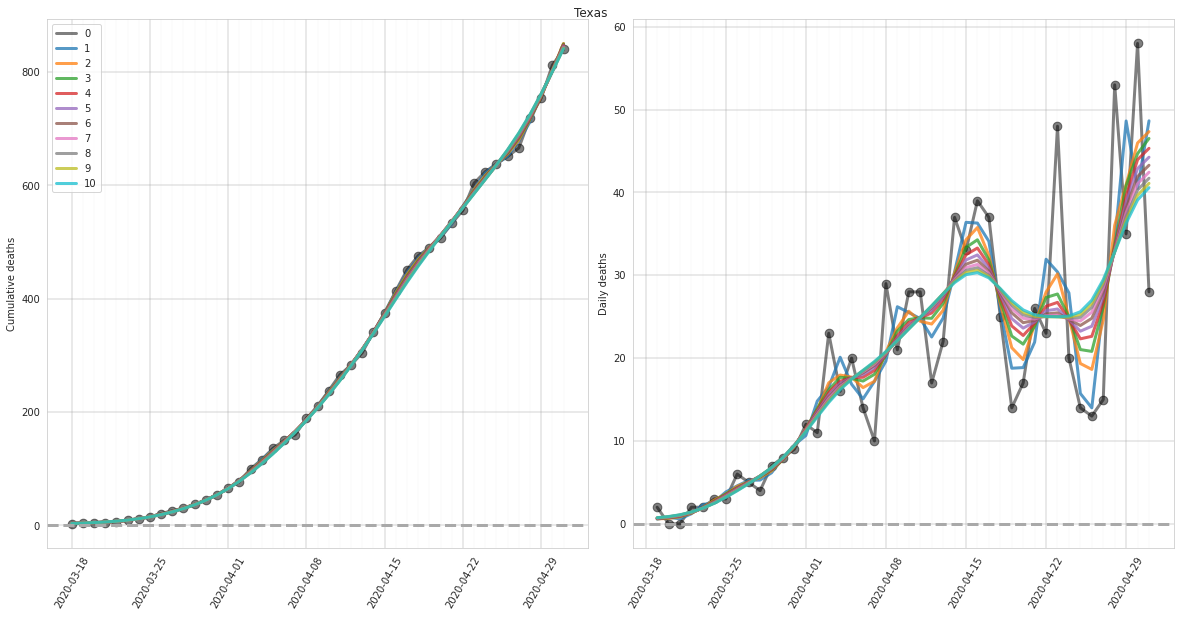

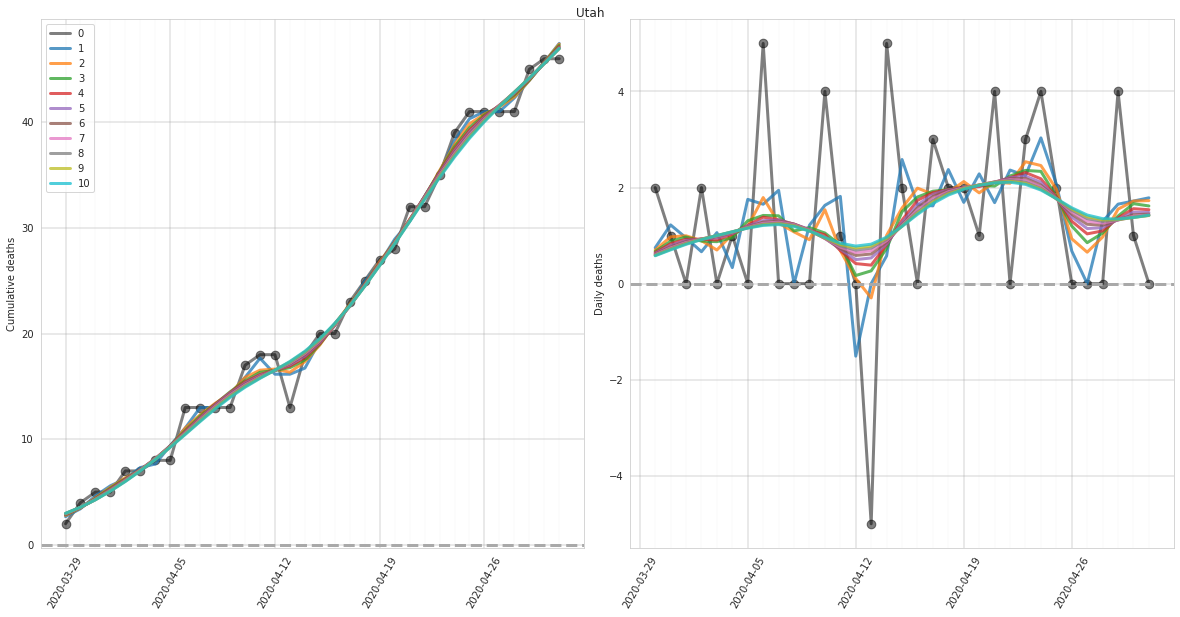

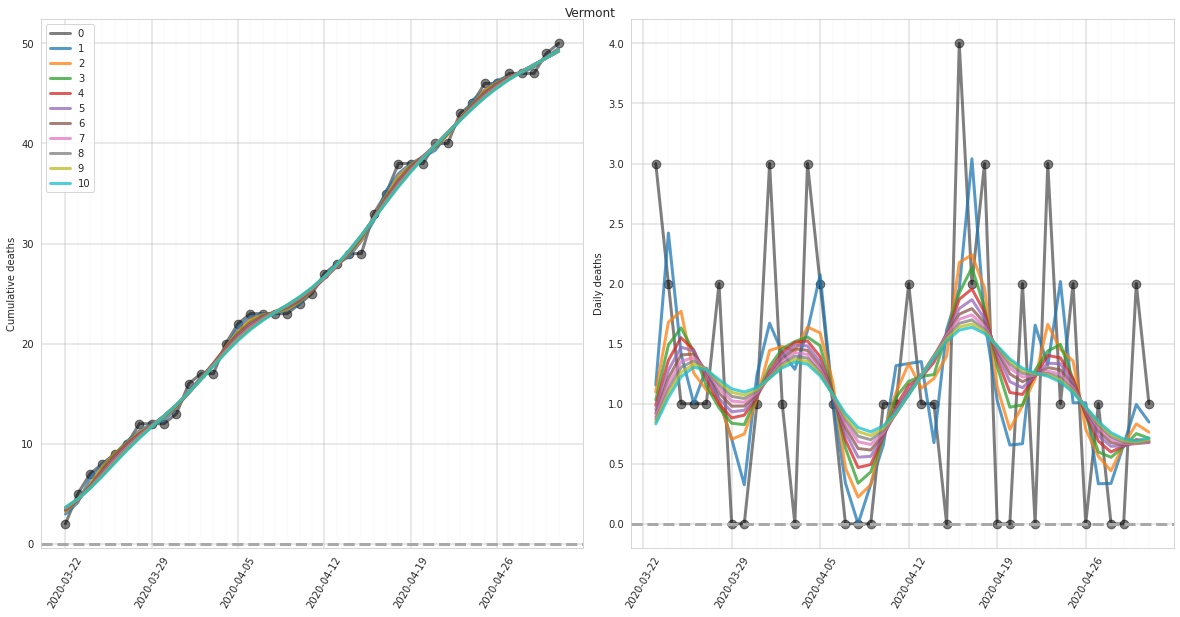

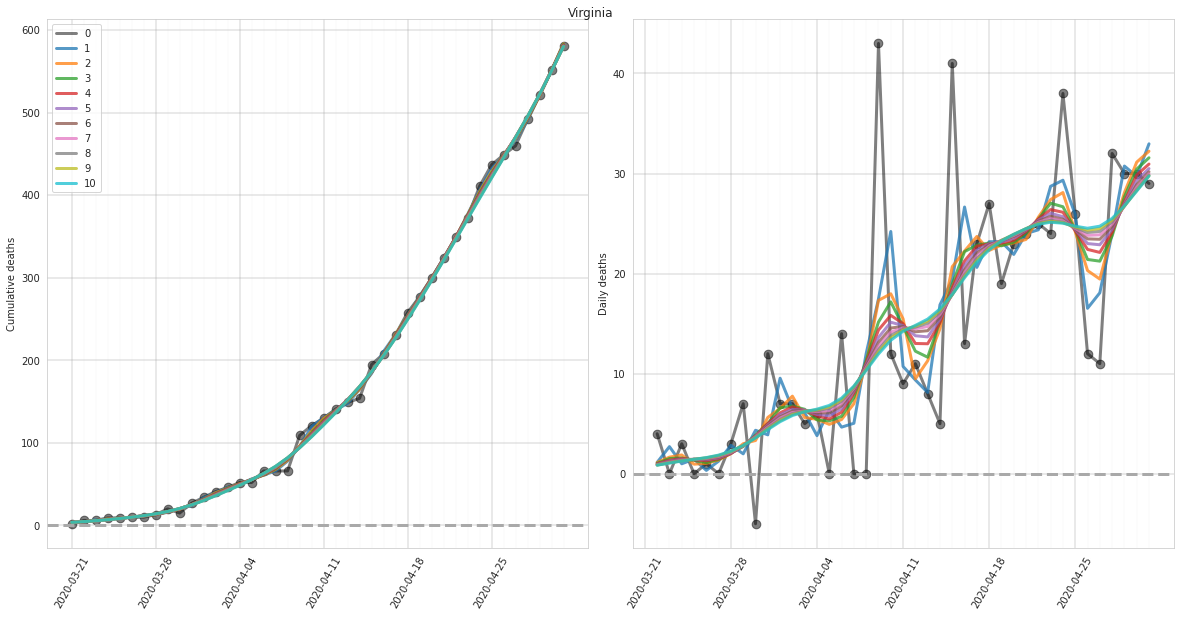

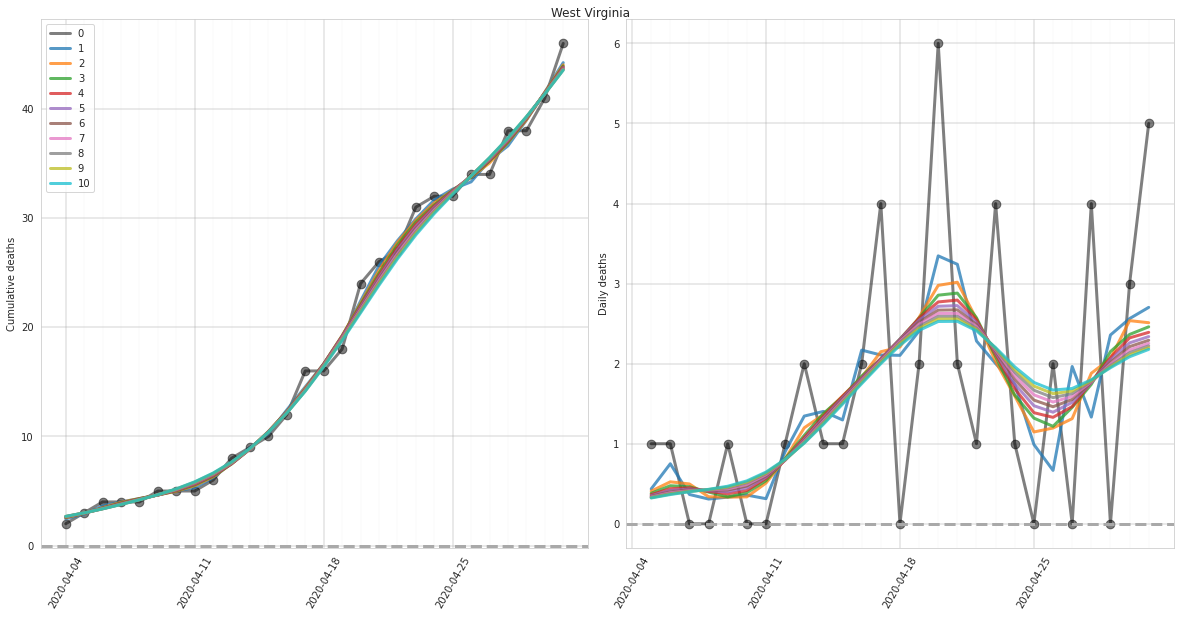

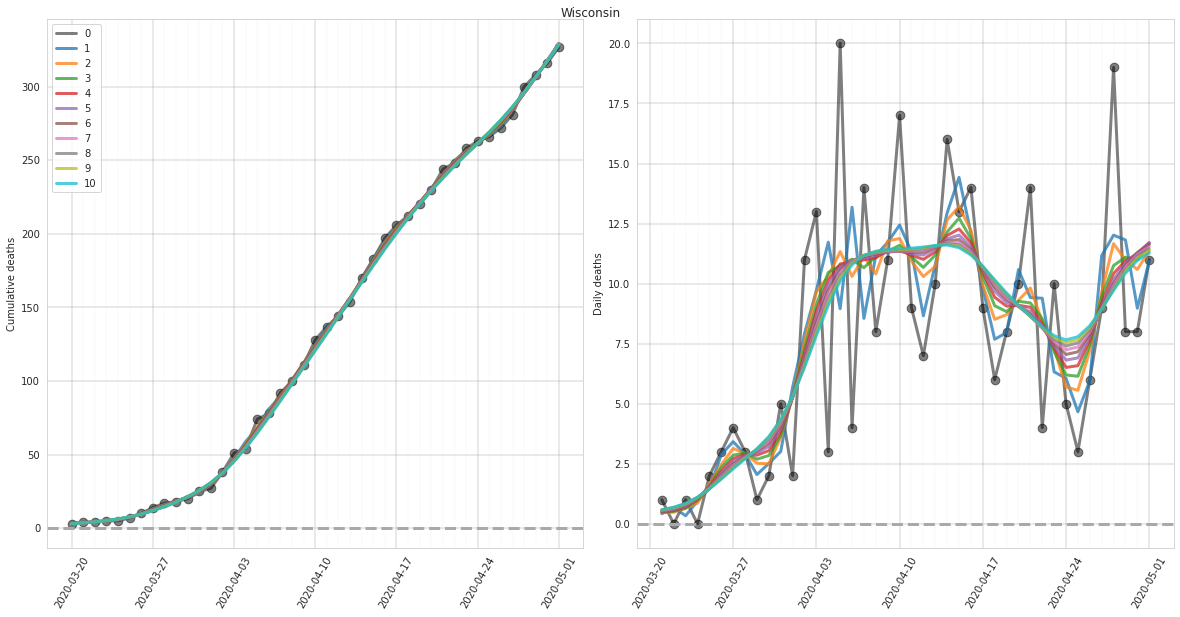

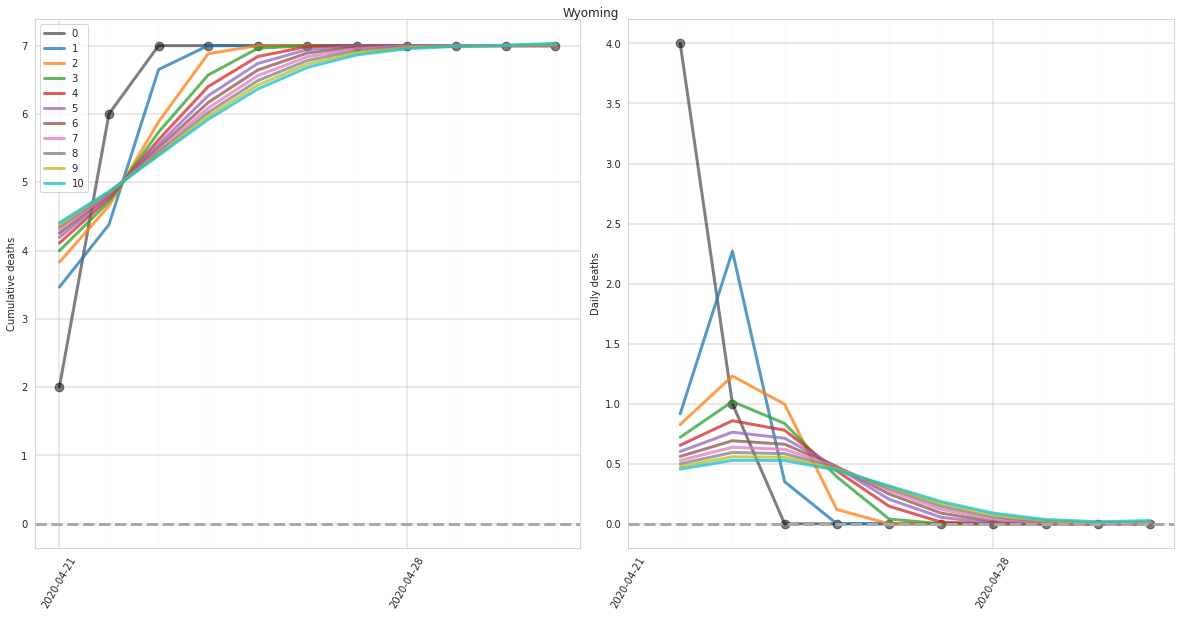

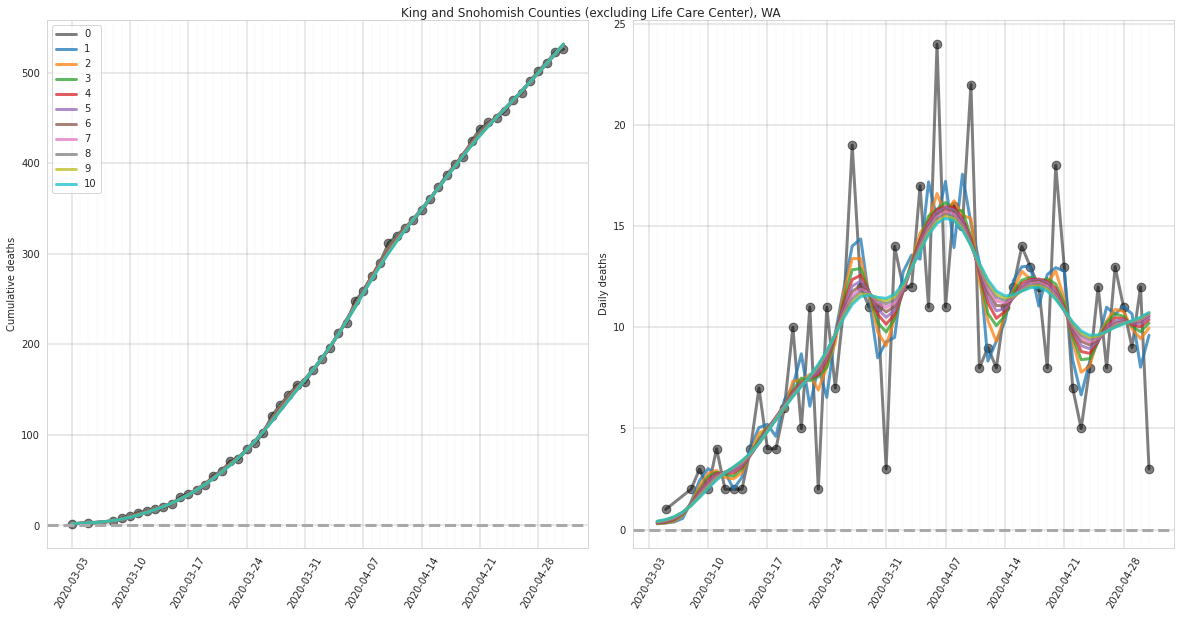

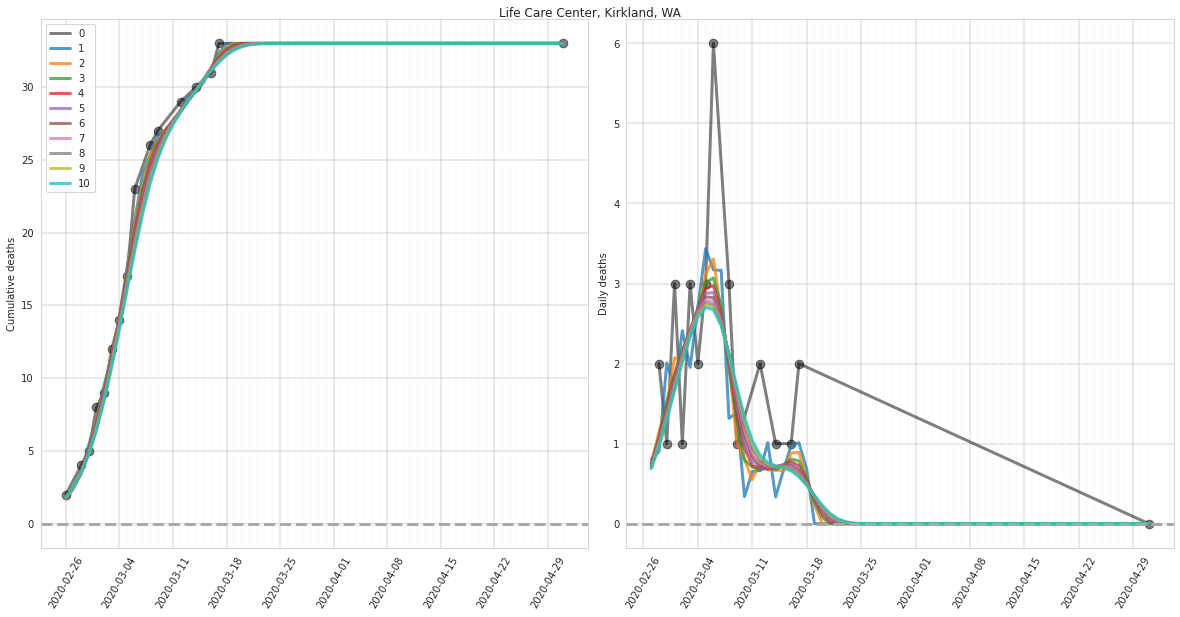

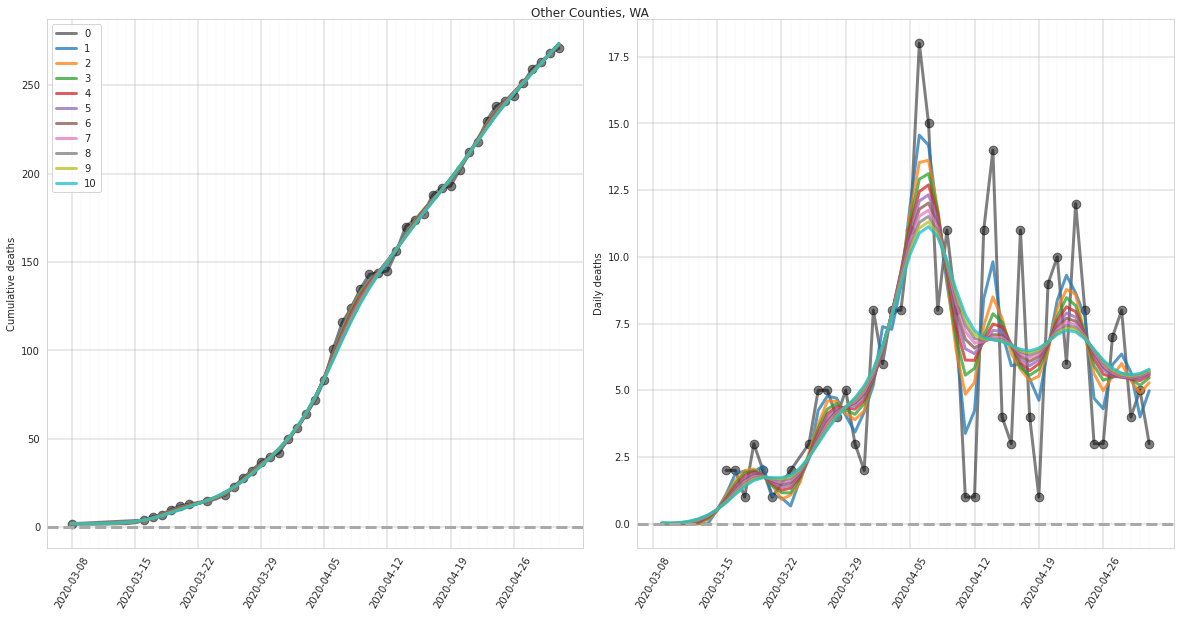

In [4]:
with PdfPages('/ihme/homes/rmbarber/covid-19/smoothing_effect.pdf') as pdf:
    for state in states:
        # set up figure
        fig, ax = plt.subplots(1, 2, figsize=(16.5, 8.5))
        
        # plot the data
        for n_smooths, smooth_df in enumerate(smooth_dfs):
            plot_df = smooth_df.loc[smooth_df['Location'] == state].reset_index(drop=True)
            if n_smooths == 0:
                metadata = dict(color='black', linewidth=3, alpha=0.5, label=n_smooths)
            else:
                metadata = dict(linewidth=3, alpha=0.75, label=n_smooths)
            if n_smooths == 0:
                ax[0].scatter(plot_df['Date'], 
                              np.exp(plot_df['ln(death rate)']) * plot_df['population'],
                              c='black', s=75, alpha=0.5)
                ax[1].scatter(plot_df['Date'][1:], 
                              (np.exp(plot_df['ln(death rate)']) * plot_df['population']).values[1:] - \
                              (np.exp(plot_df['ln(death rate)']) * plot_df['population']).values[:-1],
                              c='black', s=75, alpha=0.5)
            ax[0].plot(plot_df['Date'], 
                       np.exp(plot_df['ln(death rate)']) * plot_df['population'],
                       **metadata)
            ax[1].plot(plot_df['Date'][1:], 
                       (np.exp(plot_df['ln(death rate)']) * plot_df['population']).values[1:] - \
                       (np.exp(plot_df['ln(death rate)']) * plot_df['population']).values[:-1],
                       **metadata)
            
        # major ticks every week, minor ticks every day
        major_ticks = np.arange(0, 70, 7)
        major_ticks = np.array([plot_df['Date'].min() + timedelta(days=int(t)) for t in major_ticks])
        major_ticks = major_ticks[major_ticks <= plot_df['Date'].max()]
        minor_ticks = np.arange(0, 70)
        minor_ticks = np.array([plot_df['Date'].min() + timedelta(days=int(t)) for t in minor_ticks])
        minor_ticks = minor_ticks[minor_ticks <= plot_df['Date'].max()]
        ax[0].set_xticks(major_ticks)
        ax[0].set_xticks(minor_ticks, minor=True)
        ax[0].grid(axis='y', which='major', color='darkgrey', alpha=0.25, linewidth=2)
        ax[0].grid(axis='x', which='major', color='darkgrey', alpha=0.25, linewidth=2)
        ax[0].grid(axis='x', which='minor', color='darkgrey', alpha=0.25, linewidth=0.2)
        ax[1].set_xticks(major_ticks)
        ax[1].set_xticks(minor_ticks, minor=True)
        ax[1].grid(axis='y', which='major', color='darkgrey', alpha=0.25, linewidth=2)
        ax[1].grid(axis='x', which='major', color='darkgrey', alpha=0.25, linewidth=2)
        ax[1].grid(axis='x', which='minor', color='darkgrey', alpha=0.25, linewidth=0.2)
        
        # other settings
        
        ax[0].set_ylabel('Cumulative deaths')
        ax[0].axhline(0, color='darkgrey', linestyle='--', linewidth=3)
        ax[0].tick_params(axis='x', rotation=60)
        ax[1].set_ylabel('Daily deaths')
        ax[1].axhline(0, color='darkgrey', linestyle='--', linewidth=3)
        ax[1].tick_params(axis='x', rotation=60) 
        
        # legend
        ax[0].legend(loc=2)
        
        # title
        plt.suptitle(state, y=1.0025)
        
        # save
        plt.tight_layout()
        pdf.savefig()
